# IS843: Big Data Analytics for Business
# Project Title: Analyzing the Impact of Education on Voter Turnout in MA & NY Counties
## Team 2:
    - Astha Flynn
    - George Kolev
    - Jacinto Lemarroy
    - Michael Peng
    - Qianru Ai
    - Yuxuan Mei

## Contents
1. Abstract 
2. Introduction
3. Problem Statement
4. Data Description
5. Data Ingestion and Cleaning
6. Exploratory Data Analysis
7. Machine Learning Modelling
8. Conclusion

# Abstract

After exploring and analyzing all of our data, we believe that higher levels of education lead to higher turnout, and that such an effect is particularly pronounced in primary elections. Interestingly, primary election turnout is positively correlated with voters with higher than high school education and negatively correlated with voters with high school or less. For the general election, those with a bachelor's degree or higher are more likely to vote while some college students or those with lower levels of education are less likely to vote. This is intuitive because people with higher levels of education tend to be more civic-minded, exercise their right to vote, and are more interested in participating in political activities. After analyzing the effect of education level on turnout, we also tried to find if there were other factors that were strongly correlated with education level and had an effect on turnout. One of the factors we examined was income level, as we believe that higher levels of education would lead to higher levels of income. But the effect of income level on turnout is not very clear and is somewhat mixed: for general elections, any income level has a negative effect while for primary elections any income level has a positive effect. If we had the opportunity and resources to conduct a deeper study, we would be interested in conducting a study at the individual voter level, including how each voter voted: whether they voted in person or by mail, or whether different levels of education and income would lead to different levels of free time and thus affect willingness to vote.

# Introduction



Voter participation is critical as it cements the legitimacy of any democratic system. Democratic governments rely on high voter turnout to maintain a democratic structure. With the overall racial and ethnic diversity of the United States increasing dramatically over the last few decades, according to U.S. Census Bureau data, it is crucial to consider the effect of diversity on voter turnout. It is well-known that voting disparity exists among different races and communities, but there is no clear answer. Further data analysis on the subject is required in order to answer that question.

# Problem Statement


This project aims at shedding some light on the issue of disparity between voter turnout and education level. **Our team hopes to determine if there is any disparity in the voter turnout between households who have completed varying degrees of education.** We will begin our analysis by looking at the east coast region because, through our initial search, we found a more significant disparity in education levels in the east coast region. This will lead to an interesting analysis. We will compare the data points at the county level to account for variations in education level and voter turnout across different parts of each state. We believe that this analysis can be further expanded to consider the types of employment, e.g., do white-collar jobs have an association or impact on voter turnout as well? Therefore, we will also consider those factors. We will be using the Educational Attainment data from the US Census American Community Survey to aid our analysis.

# Data Description

## Voter data

In the past, the global economy was not as data-driven today. Data seems to be available and easy to access via the Internet from companies to governments. But this data availability was not always the case. While data analysis is only a few decades old, the quantity of data has grown exponentially. Therefore, big data techniques are as relevant as ever to handle the vast volumes of data. 

One of the datasets that we analyzed pertains to voter data. Using Boston University's subscription to national voter files, we could attain voter data for every state in the U.S. The voter files contain records for every registered voter in the U.S. The description of the voter data is as follows:

    - A voter file exists for each state
    - Each file contains geographic, demographic, and household information
    - Each file contains the history of voting for each registered voter
    
While the voter files contain several columns, we anticipate that only a subset of columns will be relevant to our analysis. A few of these columns are related to the education characteristics of voters as well as income and demographic data.

## Education data

The second dataset that we will be using is regarding education. This dataset was obtained from the US Census Bureau, and it contains columns describing the name of the voter, educational background, race characteristics, and other demographic qualities. The data is at the voter level for the population of 18 to 24-year-olds individuals living in the United States in 2020. While the data is at the voter level, we decided to analyze both datasets based on the county level to have more consistency, breadth, and depth of data points between both datasets.

# Data Ingestion and Cleansing

## Imports

In [1]:
##Import required functions
from collections import defaultdict
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import regexp_extract, regexp_replace, col, upper
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import substring
from pyspark.sql.types import IntegerType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read Datasets from Bucket

In [3]:
# We used the following code to read the data, check our schema to see if data is loaded properly
data = "gs://project_bucket_real/notebooks/jupyter/data/"
df_ma = spark.read.format("csv")\
    .option("inferSchema", "True")\
    .option("header", "True")\
    .option("nullValue", "NA")\
    .option("delimiter", "	")\
    .load(data + 'VM2Uniform--MA--2021-01-19.tab')
df_ma = df_ma.select(
                    'County','Voters_FIPS',
                    'Board_of_Education_District', 'Board_of_Education_SubDistrict',
                    'County_Board_of_Education_District', 'County_Board_of_Education_SubDistrict',
                    'Education_Commission_District', 'Educational_Service_District',
                    'Educational_Service_Subdistrict', 'Regional_Office_of_Education_District',
                    'CommercialData_Education', 'CommercialData_AreaMedianEducationYears',
                    'CommercialDataLL_Interest_in_Education_Online_In_Household',
                    'ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G18CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P08CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P10CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P12CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P14CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P16CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P18CountyTurnoutAllRegisteredVoters',
                    'CommercialData_StateIncomeDecile',
                    'CommercialData_EstimatedHHIncome'
                    )
df_ma.printSchema()

root
 |-- County: string (nullable = true)
 |-- Voters_FIPS: integer (nullable = true)
 |-- Board_of_Education_District: string (nullable = true)
 |-- Board_of_Education_SubDistrict: string (nullable = true)
 |-- County_Board_of_Education_District: string (nullable = true)
 |-- County_Board_of_Education_SubDistrict: string (nullable = true)
 |-- Education_Commission_District: string (nullable = true)
 |-- Educational_Service_District: string (nullable = true)
 |-- Educational_Service_Subdistrict: string (nullable = true)
 |-- Regional_Office_of_Education_District: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialDataLL_Interest_in_Education_Online_In_Household: string (nullable = true)
 |-- ElectionReturns_G08CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G10CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns

In [4]:
# Read NY dataset
df_ny = spark.read.format("csv")\
    .option("inferSchema", "True")\
    .option("header", "True")\
    .option("nullValue", "NA")\
    .option("delimiter", "	")\
    .load(data + 'VM2Uniform--NY--2021-03-15.tab')

In [5]:
# Take a subset of columns related to education as well as voter turnout data
df_ny = df_ny.select(
                    'County', 'Voters_FIPS',
                    'Board_of_Education_District', 'Board_of_Education_SubDistrict',
                    'County_Board_of_Education_District', 'County_Board_of_Education_SubDistrict',
                    'Education_Commission_District', 'Educational_Service_District',
                    'Educational_Service_Subdistrict', 'Regional_Office_of_Education_District',
                    'CommercialData_Education', 'CommercialData_AreaMedianEducationYears',
                    'CommercialDataLL_Interest_in_Education_Online_In_Household',
                    'ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_G18CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P08CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P10CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P12CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P14CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P16CountyTurnoutAllRegisteredVoters',
                    'ElectionReturns_P18CountyTurnoutAllRegisteredVoters',
                    'CommercialData_StateIncomeDecile',
                    'CommercialData_EstimatedHHIncome'
                    )
# Check our NY sub dataset schema 
df_ny.printSchema()

root
 |-- County: string (nullable = true)
 |-- Voters_FIPS: integer (nullable = true)
 |-- Board_of_Education_District: string (nullable = true)
 |-- Board_of_Education_SubDistrict: string (nullable = true)
 |-- County_Board_of_Education_District: string (nullable = true)
 |-- County_Board_of_Education_SubDistrict: string (nullable = true)
 |-- Education_Commission_District: string (nullable = true)
 |-- Educational_Service_District: string (nullable = true)
 |-- Educational_Service_Subdistrict: string (nullable = true)
 |-- Regional_Office_of_Education_District: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialDataLL_Interest_in_Education_Online_In_Household: string (nullable = true)
 |-- ElectionReturns_G08CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G10CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns

In [6]:
# Read the supplemental education dataset from US Census Bureau
df_edu = spark.read.format("csv")\
    .option("inferSchema", "True")\
    .option("header", "True")\
    .option("nullValue", "(X)")\
    .load(data + 'MA&NY_ASCCT5Y2020.csv')

The Education dataset from US Census Bureau contains datatype inconsistency issue, which is caused by null values with more than one respresentations.

### Concactenate MA and NY datasets together

In [7]:
df_east = df_ma.union(df_ny)

In [8]:
df_east.count()

17143289

## Data Cleaning

First, we'll look at a small sample of our dataset (small enough to fit in-memory for conversion and use in Pandas) and extrapolate findings on the sampled dataset for which columns to ultimately retain for full analysis on the full dataset.

Later on, we'll also use this smaller data set for early parts of exploratory data analysis, in which we'll show why the MA and NY data set alone is flawed for comparing education and voter turnout. This will motivate our use of the US Census data set on educational attainment. We will use the full US Census educational attainment data set, which presents data at the county-level. Therefore, we can also continue using our subset of the voter turnout data set, since county-level turnout is available in each row and using the full data set only adds more voter-level information. The amount of county-level information available is the same regardless of whether we use the sampled voter turnout data or the full voter turnout data, so we will continue to use the former for efficiency.

## Keep columns of interest

In [9]:
# Sample our MA + NY voter turnout dataset first
df_east_sample = df_east.sample(withReplacement = False, fraction = 0.25, seed = 42)

# Convert to Pandas
pd_east_sample = df_east_sample.toPandas()

pd_east_sample.head()

22/05/01 23:56:40 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,County,Voters_FIPS,Board_of_Education_District,Board_of_Education_SubDistrict,County_Board_of_Education_District,County_Board_of_Education_SubDistrict,Education_Commission_District,Educational_Service_District,Educational_Service_Subdistrict,Regional_Office_of_Education_District,...,ElectionReturns_G16CountyTurnoutAllRegisteredVoters,ElectionReturns_G18CountyTurnoutAllRegisteredVoters,ElectionReturns_P08CountyTurnoutAllRegisteredVoters,ElectionReturns_P10CountyTurnoutAllRegisteredVoters,ElectionReturns_P12CountyTurnoutAllRegisteredVoters,ElectionReturns_P14CountyTurnoutAllRegisteredVoters,ElectionReturns_P16CountyTurnoutAllRegisteredVoters,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,CommercialData_StateIncomeDecile,CommercialData_EstimatedHHIncome
0,BARNSTABLE,1,None,None,None,None,None,None,None,None,...,79%,68%,18%,26%,18%,22%,19%,27%,2.0,$50000-74999
1,BARNSTABLE,1,None,None,None,None,None,None,None,None,...,79%,68%,18%,26%,18%,22%,19%,27%,3.0,$75000-99999
2,BARNSTABLE,1,None,None,None,None,None,None,None,None,...,79%,68%,18%,26%,18%,22%,19%,27%,6.0,$125000-149999
3,BARNSTABLE,1,None,None,None,None,None,None,None,None,...,79%,68%,18%,26%,18%,22%,19%,27%,5.0,$125000-149999
4,BARNSTABLE,1,None,None,None,None,None,None,None,None,...,79%,68%,18%,26%,18%,22%,19%,27%,3.0,$200000-249999


In [10]:
# Caching the sample
df_east_sample = df_east_sample.repartition(20)
print("data was re-partitioned to {} partitions!".format(df_east_sample.rdd.getNumPartitions()))

# Setting the number of shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "20")

# Caching the DataFrame
df_east_sample.cache()

data was re-partitioned to 20 partitions!


DataFrame[County: string, Voters_FIPS: int, Board_of_Education_District: string, Board_of_Education_SubDistrict: string, County_Board_of_Education_District: string, County_Board_of_Education_SubDistrict: string, Education_Commission_District: string, Educational_Service_District: string, Educational_Service_Subdistrict: string, Regional_Office_of_Education_District: string, CommercialData_Education: string, CommercialData_AreaMedianEducationYears: int, CommercialDataLL_Interest_in_Education_Online_In_Household: string, ElectionReturns_G08CountyTurnoutAllRegisteredVoters: string, ElectionReturns_G10CountyTurnoutAllRegisteredVoters: string, ElectionReturns_G12CountyTurnoutAllRegisteredVoters: string, ElectionReturns_G14CountyTurnoutAllRegisteredVoters: string, ElectionReturns_G16CountyTurnoutAllRegisteredVoters: string, ElectionReturns_G18CountyTurnoutAllRegisteredVoters: string, ElectionReturns_P08CountyTurnoutAllRegisteredVoters: string, ElectionReturns_P10CountyTurnoutAllRegisteredVot

In [11]:
# Take a look at percentage data missing of our selected columns
pd_east_sample.isnull().sum()/len(pd_east_sample)

County                                                        0.000000
Voters_FIPS                                                   0.000000
Board_of_Education_District                                   1.000000
Board_of_Education_SubDistrict                                1.000000
County_Board_of_Education_District                            1.000000
County_Board_of_Education_SubDistrict                         1.000000
Education_Commission_District                                 1.000000
Educational_Service_District                                  1.000000
Educational_Service_Subdistrict                               1.000000
Regional_Office_of_Education_District                         1.000000
CommercialData_Education                                      0.403178
CommercialData_AreaMedianEducationYears                       0.038577
CommercialDataLL_Interest_in_Education_Online_In_Household    0.949330
ElectionReturns_G08CountyTurnoutAllRegisteredVoters           0.000000
Electi

In [12]:
# Drop columns with over 50% of missing values
pd_east_sample.drop(columns = ['Board_of_Education_District', 'Board_of_Education_SubDistrict',
                            'County_Board_of_Education_District', 'County_Board_of_Education_SubDistrict',
                            'Education_Commission_District', 'Educational_Service_District',
                            'Educational_Service_Subdistrict', 'Regional_Office_of_Education_District',
                            'CommercialDataLL_Interest_in_Education_Online_In_Household'], inplace = True)

In [13]:
# Examine income columns
pd_east_sample.CommercialData_StateIncomeDecile.value_counts()

9.0    469684
8.0    455561
7.0    436350
6.0    424984
5.0    415066
4.0    397687
3.0    396298
0.0    379305
1.0    373237
2.0    373181
Name: CommercialData_StateIncomeDecile, dtype: int64

In [14]:
pd_east_sample.CommercialData_EstimatedHHIncome.unique()

array(['$50000-74999', '$75000-99999', '$125000-149999', '$200000-249999',
       '$150000-174999', None, '$250000+', '$100000-124999',
       '$35000-49999', '$175000-199999', '$15000-24999', '$1000-14999',
       '$25000-34999'], dtype=object)

In [15]:
df_east_sample = df_east_sample.drop('Board_of_Education_District', 'Board_of_Education_SubDistrict',
                            'County_Board_of_Education_District', 'County_Board_of_Education_SubDistrict',
                            'Education_Commission_District', 'Educational_Service_District',
                            'Educational_Service_Subdistrict', 'Regional_Office_of_Education_District',
                            'CommercialDataLL_Interest_in_Education_Online_In_Household')

##Print schema to examine output
df_east_sample.printSchema()

root
 |-- County: string (nullable = true)
 |-- Voters_FIPS: integer (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- ElectionReturns_G08CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G10CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G12CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G14CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G16CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_G18CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_P08CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_P10CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_P12CountyTurnoutAllRegisteredVoters: string (nullable = true)
 |-- ElectionReturns_P14CountyTurnoutA

## Data type inconsistency handling

In [16]:
# replace percentage character in voter turnout columns
df_east_sample = df_east_sample.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G08CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G10CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G10CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G12CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G12CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G14CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G14CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G16CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G16CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G18CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_G18CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P08CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P08CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P10CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P10CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P12CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P12CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P14CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P14CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P16CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P16CountyTurnoutAllRegisteredVoters', '%', ''))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P18CountyTurnoutAllRegisteredVoters"
                                           ,regexp_replace('ElectionReturns_P18CountyTurnoutAllRegisteredVoters', '%', ''))

In [17]:
# convert string type to double for numeric columns
df_east_sample = df_east_sample.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G08CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G10CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G10CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G12CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G12CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G14CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G14CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G16CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G16CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_G18CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_G18CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P08CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P08CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P10CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P10CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P12CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P12CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P14CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P14CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P16CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P16CountyTurnoutAllRegisteredVoters.cast('double'))
df_east_sample = df_east_sample.withColumn("ElectionReturns_P18CountyTurnoutAllRegisteredVoters"
                                           ,df_east_sample.ElectionReturns_P18CountyTurnoutAllRegisteredVoters.cast('double'))

In [18]:
# chech schema again
df_east_sample.printSchema()

root
 |-- County: string (nullable = true)
 |-- Voters_FIPS: integer (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- ElectionReturns_G08CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_G10CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_G12CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_G14CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_G16CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_G18CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P08CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P10CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P12CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P14CountyTurnoutA

## Missing value imputation / drop

In [19]:
# Check missing values
pd_east_sample.isnull().sum()/len(pd_east_sample)

County                                                 0.000000
Voters_FIPS                                            0.000000
CommercialData_Education                               0.403178
CommercialData_AreaMedianEducationYears                0.038577
ElectionReturns_G08CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_G10CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_G12CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_G14CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_G16CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_G18CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P08CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P10CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P12CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P14CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P16CountyTurnoutAllRegisteredVoters    0.000000
ElectionReturns_P18CountyTurnoutAllRegis

**check the distribution of CommercialData_StateIncomeDecile to decide missing value handling method.**

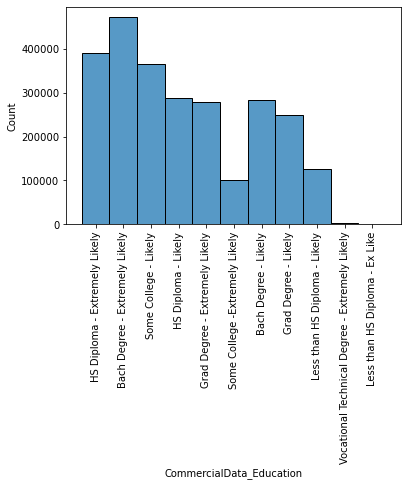

In [20]:
# check the distribution of CommercialData_Education, a categorical variable
sns.histplot(pd_east_sample.CommercialData_Education)
plt.tick_params(axis='x', rotation=90)

Since there's 40% data missing, we will fill them with 'Unknown'.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CommercialData_AreaMedianEducationYears'>

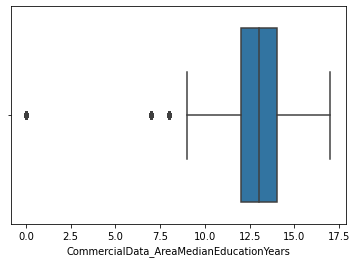

In [21]:
# check the distribution of CommercialData_AreaMedianEducationYears
sns.boxplot(pd_east_sample.CommercialData_AreaMedianEducationYears)

There are a few outliers, but no outlier handling is needed since it's likely not to be false data.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CommercialData_StateIncomeDecile'>

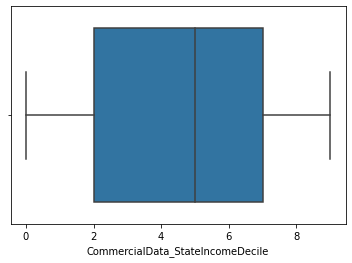

In [22]:
# check the distribution of CommercialData_StateIncomeDecile
sns.boxplot(pd_east_sample.CommercialData_StateIncomeDecile)

We can fill the 3% missing values with mean.

In [23]:
# Calculate the average education years for missing value imputation
mean_edu = pd_east_sample.CommercialData_AreaMedianEducationYears.mean()
mean_income_decile = pd_east_sample.CommercialData_StateIncomeDecile.mean()

In [24]:
# Fill missing values with different methods
# fill CommercialData_Education and CommercialData_EstimatedHHIncome with unknown to avoid introducing bias
# fill CommercialData_AreaMedianEducationYears with average education years
# fill CommercialData_EstimatedHHIncome with unknown to avoid introducing bias
df_east_sample = df_east_sample.na.fill({'CommercialData_Education':'Unknown',
                       'CommercialData_AreaMedianEducationYears': mean_edu,
                       'CommercialData_EstimatedHHIncome': 'Unknown',
                       'CommercialData_StateIncomeDecile':mean_income_decile})

In [25]:
# check if successfully imputed missing values
df_east_sample.toPandas().isnull().sum()

County                                                 0
Voters_FIPS                                            0
CommercialData_Education                               0
CommercialData_AreaMedianEducationYears                0
ElectionReturns_G08CountyTurnoutAllRegisteredVoters    0
ElectionReturns_G10CountyTurnoutAllRegisteredVoters    0
ElectionReturns_G12CountyTurnoutAllRegisteredVoters    0
ElectionReturns_G14CountyTurnoutAllRegisteredVoters    0
ElectionReturns_G16CountyTurnoutAllRegisteredVoters    0
ElectionReturns_G18CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P08CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P10CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P12CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P14CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P16CountyTurnoutAllRegisteredVoters    0
ElectionReturns_P18CountyTurnoutAllRegisteredVoters    0
CommercialData_StateIncomeDecile                       0
CommercialData_EstimatedHHIncom

In [26]:
# Display our MA and NY cleaned data result with pandas dataframe
df_east_sample.toPandas().head(5)

,County,Voters_FIPS,CommercialData_Education,CommercialData_AreaMedianEducationYears,ElectionReturns_G08CountyTurnoutAllRegisteredVoters,ElectionReturns_G10CountyTurnoutAllRegisteredVoters,ElectionReturns_G12CountyTurnoutAllRegisteredVoters,ElectionReturns_G14CountyTurnoutAllRegisteredVoters,ElectionReturns_G16CountyTurnoutAllRegisteredVoters,ElectionReturns_G18CountyTurnoutAllRegisteredVoters,ElectionReturns_P08CountyTurnoutAllRegisteredVoters,ElectionReturns_P10CountyTurnoutAllRegisteredVoters,ElectionReturns_P12CountyTurnoutAllRegisteredVoters,ElectionReturns_P14CountyTurnoutAllRegisteredVoters,ElectionReturns_P16CountyTurnoutAllRegisteredVoters,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,CommercialData_StateIncomeDecile,CommercialData_EstimatedHHIncome
0,BARNSTABLE,1,Unknown,13,79.0,65.0,79.0,59.0,79.0,68.0,18.0,26.0,18.0,22.0,19.0,27.0,4,$200000-249999
1,BARNSTABLE,1,Bach Degree - Extremely Likely,13,79.0,65.0,79.0,59.0,79.0,68.0,18.0,26.0,18.0,22.0,19.0,27.0,3,$175000-199999
2,BARNSTABLE,1,HS Diploma - Likely,13,79.0,65.0,79.0,59.0,79.0,68.0,18.0,26.0,18.0,22.0,19.0,27.0,4,$50000-74999
3,BARNSTABLE,1,Some College - Likely,13,79.0,65.0,79.0,59.0,79.0,68.0,18.0,26.0,18.0,22.0,19.0,27.0,4,$175000-199999
4,BARNSTABLE,1,Bach Degree - Extremely Likely,12,79.0,65.0,79.0,59.0,79.0,68.0,18.0,26.0,18.0,22.0,19.0,27.0,3,$75000-99999


In [27]:
pd_east_sample.head()

,County,Voters_FIPS,CommercialData_Education,CommercialData_AreaMedianEducationYears,ElectionReturns_G08CountyTurnoutAllRegisteredVoters,ElectionReturns_G10CountyTurnoutAllRegisteredVoters,ElectionReturns_G12CountyTurnoutAllRegisteredVoters,ElectionReturns_G14CountyTurnoutAllRegisteredVoters,ElectionReturns_G16CountyTurnoutAllRegisteredVoters,ElectionReturns_G18CountyTurnoutAllRegisteredVoters,ElectionReturns_P08CountyTurnoutAllRegisteredVoters,ElectionReturns_P10CountyTurnoutAllRegisteredVoters,ElectionReturns_P12CountyTurnoutAllRegisteredVoters,ElectionReturns_P14CountyTurnoutAllRegisteredVoters,ElectionReturns_P16CountyTurnoutAllRegisteredVoters,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,CommercialData_StateIncomeDecile,CommercialData_EstimatedHHIncome
0,BARNSTABLE,1,HS Diploma - Extremely Likely,12.0,79%,65%,79%,59%,79%,68%,18%,26%,18%,22%,19%,27%,2.0,$50000-74999
1,BARNSTABLE,1,None,12.0,79%,65%,79%,59%,79%,68%,18%,26%,18%,22%,19%,27%,3.0,$75000-99999
2,BARNSTABLE,1,None,14.0,79%,65%,79%,59%,79%,68%,18%,26%,18%,22%,19%,27%,6.0,$125000-149999
3,BARNSTABLE,1,Bach Degree - Extremely Likely,13.0,79%,65%,79%,59%,79%,68%,18%,26%,18%,22%,19%,27%,5.0,$125000-149999
4,BARNSTABLE,1,Some College - Likely,13.0,79%,65%,79%,59%,79%,68%,18%,26%,18%,22%,19%,27%,3.0,$200000-249999


## Data Cleansing on Education dataframe

In [28]:
df_edu.toPandas().isnull().sum()

GEO_ID             0
NAME               0
S1501_C01_001E     0
S1501_C01_001M     0
S1501_C01_002E     0
                  ..
S1501_C06_062M    77
S1501_C06_063E    77
S1501_C06_063M    77
S1501_C06_064E    77
S1501_C06_064M    77
Length: 770, dtype: int64

In [29]:
# get columns names with data type inconsistentency problem
cols = []
for _col in df_edu.dtypes:
    if _col[1] == 'string':
        cols.append(_col[0])

In [30]:
# convert data type to float for all numeric columns
cols = cols[2:]  # Exclude id and name column
for col_name in cols:
    df_edu = df_edu.withColumn(col_name, col(col_name).cast('float'))

In [31]:
# Check missing values
df_edu.toPandas().isnull().sum()/len(df_edu.toPandas())

GEO_ID            0.0
NAME              0.0
S1501_C01_001E    0.0
S1501_C01_001M    0.0
S1501_C01_002E    0.0
                 ... 
S1501_C06_062M    1.0
S1501_C06_063E    1.0
S1501_C06_063M    1.0
S1501_C06_064E    1.0
S1501_C06_064M    1.0
Length: 770, dtype: float64

In [32]:
# Display one of the columns with too many missing values
df_edu.select("S1501_C01_052M").show()

+--------------+
|S1501_C01_052M|
+--------------+
|          94.0|
|          null|
|          null|
|         112.0|
|          null|
|          71.0|
|          null|
|          null|
|          null|
|         200.0|
|          null|
|          null|
|          null|
|          null|
|          null|
|          33.0|
|          null|
|          null|
|          64.0|
|          44.0|
+--------------+
only showing top 20 rows



In [33]:
# convert to pandas dataframe then drop columns with too many empty values
df_edu = df_edu.toPandas().dropna(axis='columns', thresh = int(0.80 * df_edu.count()))

# Check missing values now
df_edu.isnull().sum().max()

2

In [34]:
# Since there're only the maximum missing values per column is 2, 
# we will fill the rest of missing values with mean
df_edu.fillna(df_edu.mean(), inplace=True)

# Confirm the missing values again
df_edu.isnull().sum().max()

0

In [35]:
# convert back to Spark dataframe
df_edu = spark.createDataFrame(df_edu)

## Merge with Education Dataset from US Census Bureau

Since the FIPS code in the NY_MA voting dataset only has two digits, we can't directly merge on the FIPS code. We will merge the two datasets using County name as a primary key, and FIPS code as a secondary key.

In [36]:
# extract county names from the Education dataframe using regex
df_edu = df_edu.withColumn("County", regexp_extract(col('NAME'), '(.+)(\s)(County)(.)', 1))

In [37]:
# Convert county name to upper case to match with original dataset
df_edu = df_edu.withColumn("County", upper(col('County')))

In [38]:
# Slice the last two digits of GEO_ID to match with FIPS code
df_edu = df_edu.withColumn("Voters_FIPS", substring('GEO_ID', 12,3))

# Cast the sliced string back to int to match with the NY_MA FIPS code format
df_edu = df_edu.withColumn("Voters_FIPS", col('Voters_FIPS').cast(IntegerType()))
df_east_sample.withColumn("Voters_FIPS", col('Voters_FIPS').cast(IntegerType()))

DataFrame[County: string, Voters_FIPS: int, CommercialData_Education: string, CommercialData_AreaMedianEducationYears: int, ElectionReturns_G08CountyTurnoutAllRegisteredVoters: double, ElectionReturns_G10CountyTurnoutAllRegisteredVoters: double, ElectionReturns_G12CountyTurnoutAllRegisteredVoters: double, ElectionReturns_G14CountyTurnoutAllRegisteredVoters: double, ElectionReturns_G16CountyTurnoutAllRegisteredVoters: double, ElectionReturns_G18CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P08CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P10CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P12CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P14CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P16CountyTurnoutAllRegisteredVoters: double, ElectionReturns_P18CountyTurnoutAllRegisteredVoters: double, CommercialData_StateIncomeDecile: int, CommercialData_EstimatedHHIncome: string]

In [39]:
# check if succeed
df_edu.toPandas().head(5)

,GEO_ID,NAME,S1501_C01_001E,S1501_C01_001M,S1501_C01_002E,S1501_C01_002M,S1501_C01_003E,S1501_C01_003M,S1501_C01_004E,S1501_C01_004M,...,S1501_C06_055E,S1501_C06_055M,S1501_C06_056E,S1501_C06_056M,S1501_C06_057E,S1501_C06_057M,S1501_C06_058E,S1501_C06_058M,County,Voters_FIPS
0,0500000US25001,"Barnstable County, Massachusetts",14900,172,1934,327,5008,569,5134,593,...,14.1,3.9,10.0,1.6,8.6,1.5,4.5,0.8,BARNSTABLE,1.0
1,0500000US25003,"Berkshire County, Massachusetts",11936,166,1190,208,3390,368,6201,396,...,22.4,5.2,12.0,2.1,9.3,1.7,4.2,0.9,BERKSHIRE,3.0
2,0500000US25005,"Bristol County, Massachusetts",50816,104,6099,615,18257,938,20117,883,...,23.6,2.1,12.5,1.3,10.5,1.0,4.0,0.6,BRISTOL,5.0
3,0500000US25007,"Dukes County, Massachusetts",1201,183,265,168,280,153,535,223,...,17.3,23.5,19.8,14.0,6.3,4.4,2.8,1.8,DUKES,7.0
4,0500000US25009,"Essex County, Massachusetts",72181,83,9319,689,22524,1106,28294,1219,...,27.7,2.4,16.0,1.4,9.7,0.9,4.2,0.5,ESSEX,9.0


In [40]:
# Join NY_MA voting dataset with education dataset on county and GEO_ID/FIPS code
df_all = df_east_sample.join(df_edu, on = ["County", "Voters_FIPS"], how = "left_outer")

The below blocks can be uncommented for either of the data sets if we wish to write them to an external file for ease of future use

In [ ]:
# ## Write to .csv for dashboard
# df_sample = df_all.sample(fraction = 0.1)
# df_sample.write.csv("gs://project_bucket_real/notebooks/jupyter/data/dashboard_data.csv") 

In [ ]:
# ## Write to parquet
# df_all.write.parquet("gs://project_bucket_real/notebooks/jupyter/data/final_df_0429.parquet") 

# Exploratory Data Analysis

For this part, we mainly focus on the following questions:
1. What has been the trend in voter turnout over the past few years?
2. Does education level have any impact on voting turnout?
3. Is there disparity in turnout between primary and general election for different education levels?
4. What other factors, such as income disparity impact on voting, could confound education as a factor?

As stated in the data cleansing section, we'll continue to use a subset of the MA + NY voter turnout data with the full set of US Census educational attainment data. Most of the analysis will use county-level information from the voter turnout data set, so we only need to use a subset that is large enough that there is a row for each county. At that point, increasing the amount of voter turnout data used (in terms of number of rows) won't add additional information since this increases only voter-level information, not county-level information. Thus, we can perform EDA quickly and efficiently, without loss of information.

The one case where the above assumption does not hold is in our initial EDA that uses voter-level educational information from the voter turnout data set. However, the sampled voter turnout data is large enough for us to showcase the issues with trying to use the educational information available in the MA and NY voter turnout data sets. The issues we will point out persist regardless of the sampled size of the voter turnout data set, and motivate why we need to use the educational information provided by the full US Census educational attainment data set.

## Convert voter-level data to county-level

The above df has all the information we need, but each row is for an individual voter. I.e., it is a voter-level data frame. So if we try to describe or aggregate most of the columns, which contain county-level data, then the statistics will be inappropriately weighted by the number of voters in that county. We need to also create a county-level data frame.

In [2]:
## Load data frame
try:
    df = df_sample
except:
    df = spark.read.parquet("gs://project_bucket_real/notebooks/jupyter/data/final_df_0429.parquet") 

In [3]:
df.groupBy('County', 'CommercialData_Education').count().orderBy(col('count').desc()).show()

+-----------+------------------------+------+
|     County|CommercialData_Education| count|
+-----------+------------------------+------+
|      KINGS|                 Unknown|210179|
|   NEW YORK|                 Unknown|158768|
|     QUEENS|                 Unknown|152236|
|    SUFFOLK|                 Unknown|151329|
|      BRONX|                 Unknown|119854|
|     NASSAU|                 Unknown| 95096|
|  MIDDLESEX|                 Unknown| 88722|
|WESTCHESTER|                 Unknown| 63403|
|       ERIE|                 Unknown| 52820|
|      ESSEX|                 Unknown| 48807|
|  WORCESTER|                 Unknown| 44415|
|     MONROE|                 Unknown| 42251|
|    SUFFOLK|    Bach Degree - Ext...| 38978|
|    NORFOLK|                 Unknown| 38833|
|    SUFFOLK|    HS Diploma - Extr...| 33799|
|  MIDDLESEX|    Bach Degree - Ext...| 32345|
|   RICHMOND|                 Unknown| 32229|
|    SUFFOLK|    Some College - Li...| 31817|
|    HAMPDEN|                 Unkn

In [4]:
df.groupBy('County', 'CommercialData_EstimatedHHIncome').count().orderBy(col('count').desc()).show()

+---------+--------------------------------+-----+
|   County|CommercialData_EstimatedHHIncome|count|
+---------+--------------------------------+-----+
|    KINGS|                    $50000-74999|92595|
|   QUEENS|                    $75000-99999|74702|
|   QUEENS|                    $50000-74999|73364|
| NEW YORK|                  $200000-249999|70026|
|  SUFFOLK|                    $75000-99999|62371|
|  SUFFOLK|                  $100000-124999|62042|
|    KINGS|                    $75000-99999|61573|
|  SUFFOLK|                  $125000-149999|49061|
|    KINGS|                    $35000-49999|46181|
|   NASSAU|                  $125000-149999|43440|
|  SUFFOLK|                    $50000-74999|42942|
|    BRONX|                    $35000-49999|41560|
|   QUEENS|                  $100000-124999|40831|
|MIDDLESEX|                  $100000-124999|40651|
|    BRONX|                    $50000-74999|40596|
|   NASSAU|                  $100000-124999|40536|
|MIDDLESEX|                  $1

In [5]:
county_level_df = df.dropDuplicates(['County'])

In [6]:
county_level_df.toPandas().head(5)

22/05/02 00:13:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,County,Voters_FIPS,CommercialData_Education,CommercialData_AreaMedianEducationYears,ElectionReturns_G08CountyTurnoutAllRegisteredVoters,ElectionReturns_G10CountyTurnoutAllRegisteredVoters,ElectionReturns_G12CountyTurnoutAllRegisteredVoters,ElectionReturns_G14CountyTurnoutAllRegisteredVoters,ElectionReturns_G16CountyTurnoutAllRegisteredVoters,ElectionReturns_G18CountyTurnoutAllRegisteredVoters,...,S1501_C06_054E,S1501_C06_054M,S1501_C06_055E,S1501_C06_055M,S1501_C06_056E,S1501_C06_056M,S1501_C06_057E,S1501_C06_057M,S1501_C06_058E,S1501_C06_058M
0,ALLEGANY,3,Grad Degree - Likely,12,64.0,48.0,64.0,47.0,70.0,62.0,...,35.0,23.2,31.3,6.3,18.5,3.1,14.2,2.4,5.4,2.1
1,BARNSTABLE,1,Unknown,13,79.0,65.0,79.0,59.0,79.0,68.0,...,20.7,6.1,14.1,3.9,10.0,1.6,8.6,1.5,4.5,0.8
2,BRISTOL,5,Bach Degree - Likely,12,71.0,50.0,69.0,43.0,70.0,58.0,...,17.8,3.2,23.6,2.1,12.5,1.3,10.5,1.0,4.0,0.6
3,BRONX,5,Unknown,12,54.0,26.0,53.0,20.0,52.0,38.0,...,16.1,0.7,43.0,1.3,29.1,1.4,21.3,1.0,9.6,0.9
4,BROOME,7,Unknown,12,69.0,50.0,63.0,43.0,66.0,62.0,...,31.7,9.6,32.2,4.5,16.3,2.1,14.6,2.0,5.6,1.0


In [7]:
county_level_educations = df.groupBy('County', 'CommercialData_Education').count().collect()
county_level_educations_dict = defaultdict(dict)
for row in county_level_educations:
    county_level_educations_dict[row['County']][row['CommercialData_Education']] = row['count']

In [8]:
education_level_columns = [
    'Unknown', 
    'Grad Degree - Likely', 
    'Grad Degree - Extremely Likely', 
    'Vocational Technical Degree - Extremely Likely',
    'Bach Degree - Extremely Likely',
    'Less than HS Diploma - Ex Like',
    'HS Diploma - Extremely Likely',
    'Some College - Likely',
    'Some College -Extremely Likely',
    'HS Diploma - Likely',
    'Bach Degree - Likely',
    'Less than HS Diploma - Likely'
]
data = []
for county in county_level_educations_dict.keys():
    row = [county]
    for education_level_column in education_level_columns:
        if education_level_column in county_level_educations_dict[county]:
            row.append(county_level_educations_dict[county][education_level_column])
        else:
            row.append(0)
    data.append(row)

In [9]:
columns = ["County"] + education_level_columns
county_level_education_df = spark.createDataFrame(data).toDF(*columns)

In [10]:
county_level_education_df.toPandas().head()

,County,Unknown,Grad Degree - Likely,Grad Degree - Extremely Likely,Vocational Technical Degree - Extremely Likely,Bach Degree - Extremely Likely,Less than HS Diploma - Ex Like,HS Diploma - Extremely Likely,Some College - Likely,Some College -Extremely Likely,HS Diploma - Likely,Bach Degree - Likely,Less than HS Diploma - Likely
0,ONTARIO,5977,1092,1526,20,2640,8,2336,2159,696,1212,1050,441
1,CHENANGO,2304,243,429,15,846,2,1380,701,338,864,199,337
2,HAMPSHIRE,8991,1933,2551,21,3468,4,2493,2323,819,1398,1517,430
3,HERKIMER,2940,342,578,19,1393,8,1643,1109,485,971,268,316
4,CHEMUNG,3903,533,1017,22,1604,5,2044,1483,562,960,449,329


In [11]:
county_level_df = county_level_education_df.join(county_level_df, on = "County")

In [12]:
county_level_df = county_level_df.drop('CommercialData_Education')

In [13]:
county_level_df.toPandas().head()

,County,Unknown,Grad Degree - Likely,Grad Degree - Extremely Likely,Vocational Technical Degree - Extremely Likely,Bach Degree - Extremely Likely,Less than HS Diploma - Ex Like,HS Diploma - Extremely Likely,Some College - Likely,Some College -Extremely Likely,...,S1501_C06_054E,S1501_C06_054M,S1501_C06_055E,S1501_C06_055M,S1501_C06_056E,S1501_C06_056M,S1501_C06_057E,S1501_C06_057M,S1501_C06_058E,S1501_C06_058M
0,ONTARIO,5977,1092,1526,20,2640,8,2336,2159,696,...,23.3,7.1,20.6,5.4,15.4,3.3,7.2,1.7,2.0,0.7
1,CHENANGO,2304,243,429,15,846,2,1380,701,338,...,16.1,9.2,24.6,5.9,15.9,2.8,12.2,2.6,3.9,1.8
2,HAMPSHIRE,8991,1933,2551,21,3468,4,2493,2323,819,...,47.4,7.3,19.8,6.2,11.0,2.9,10.2,2.1,5.0,1.0
3,HERKIMER,2940,342,578,19,1393,8,1643,1109,485,...,8.9,8.1,25.3,6.7,16.9,2.8,10.3,2.0,5.3,2.0
4,CHEMUNG,3903,533,1017,22,1604,5,2044,1483,562,...,28.2,12.1,39.5,7.8,17.3,3.2,11.0,2.1,4.5,2.1


In [14]:
county_level_income_levels = df.groupBy('County', 'CommercialData_EstimatedHHIncome').count().collect()
county_level_income_levels_dict = defaultdict(dict)
for row in county_level_income_levels:
    county_level_income_levels_dict[row['County']][row['CommercialData_EstimatedHHIncome']] = row['count']

In [15]:
income_level_columns = [
    '$150000-174999', '$100000-124999', '$75000-99999',
       '$125000-149999', '$50000-74999', '$175000-199999', '$35000-49999',
       '$200000-249999', '$25000-34999', '$1000-14999', '$15000-24999',
       '$250000+'
]

data = []
for county in county_level_income_levels_dict.keys():
    row = [county]
    for income_level_column in income_level_columns:
        if income_level_column in county_level_income_levels_dict[county]:
            row.append(county_level_income_levels_dict[county][income_level_column])
        else:
            row.append(0)
    data.append(row)

In [16]:
columns = ["County"] + income_level_columns
county_level_income_df = spark.createDataFrame(data).toDF(*columns)

In [17]:
county_level_income_df.toPandas().head()

,County,$150000-174999,$100000-124999,$75000-99999,$125000-149999,$50000-74999,$175000-199999,$35000-49999,$200000-249999,$25000-34999,$1000-14999,$15000-24999,$250000+
0,RICHMOND,4255,17621,14495,11085,9448,4082,4186,4403,1690,2043,1374,4505
1,BRONX,2065,8789,19230,7291,40596,1985,41560,1739,33177,13023,27632,1897
2,CHENANGO,64,405,1271,315,3044,67,915,64,431,345,428,48
3,ERIE,4512,20144,33082,13063,35571,3878,15854,3402,10287,6312,7454,4452
4,OTSEGO,159,799,1633,480,3060,170,781,112,470,330,359,178


In [18]:
county_level_df = county_level_income_df.join(county_level_df, on = "County")

In [19]:
county_level_df = county_level_df.drop('CommercialData_EstimatedHHIncome')

In [20]:
county_level_df.toPandas().head()

,County,$150000-174999,$100000-124999,$75000-99999,$125000-149999,$50000-74999,$175000-199999,$35000-49999,$200000-249999,$25000-34999,...,S1501_C06_054E,S1501_C06_054M,S1501_C06_055E,S1501_C06_055M,S1501_C06_056E,S1501_C06_056M,S1501_C06_057E,S1501_C06_057M,S1501_C06_058E,S1501_C06_058M
0,ONTARIO,426,2488,4941,2132,3904,525,1506,557,786,...,23.3,7.1,20.6,5.4,15.4,3.3,7.2,1.7,2.0,0.7
1,CHENANGO,64,405,1271,315,3044,67,915,64,431,...,16.1,9.2,24.6,5.9,15.9,2.8,12.2,2.6,3.9,1.8
2,HAMPSHIRE,1339,4823,7149,2497,2865,876,1490,844,772,...,47.4,7.3,19.8,6.2,11.0,2.9,10.2,2.1,5.0,1.0
3,HERKIMER,115,590,1764,431,3732,82,1280,94,661,...,8.9,8.1,25.3,6.7,16.9,2.8,10.3,2.0,5.3,2.0
4,CHEMUNG,121,1234,2724,678,3903,158,1414,164,1027,...,28.2,12.1,39.5,7.8,17.3,3.2,11.0,2.1,4.5,2.1


If we take a look at county-level turnout for the most recent general election (2018), it appears average turnout across MA & NY counties was 60% with min-max values of 38% and 70%

In [21]:
county_level_df.describe(['ElectionReturns_G18CountyTurnoutAllRegisteredVoters']).show()

+-------+---------------------------------------------------+
|summary|ElectionReturns_G18CountyTurnoutAllRegisteredVoters|
+-------+---------------------------------------------------+
|  count|                                                 73|
|   mean|                                 59.945205479452056|
| stddev|                                  6.195631101740841|
|    min|                                               38.0|
|    max|                                               70.0|
+-------+---------------------------------------------------+



## Explore voter turnout

Let's see how voter turnout has changed over the past 6 elections and if there is a notable difference in turnout between general and primary elections.

In [22]:
## Let's look at county level turnout over the past 6 elections
G_Turnouts = [_col for _col in county_level_df.columns if "_G" in _col]
P_Turnouts = [_col for _col in county_level_df.columns if "_P" in _col]

G_avg_turnout = [county_level_df.agg({_col: 'avg'}).collect()[0][0] for _col in G_Turnouts]
P_avg_turnout = [county_level_df.agg({_col: 'avg'}).collect()[0][0] for _col in P_Turnouts]

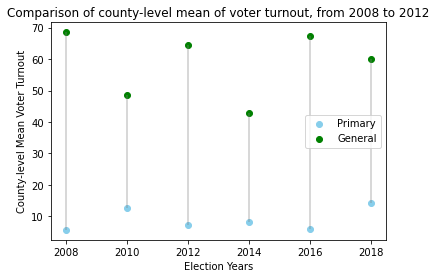

In [23]:
years = ["2008", "2010", "2012", "2014", "2016", "2018"]
temp_df = pd.DataFrame({'years': years, 'G_Avg_Turnout' : G_avg_turnout, 'P_Avg_Turnout' : P_avg_turnout})

# Make plot
plt.vlines(x=temp_df['years'], ymin=temp_df['P_Avg_Turnout'], ymax=temp_df['G_Avg_Turnout'], color='grey', alpha=0.4)
plt.scatter(temp_df['years'], temp_df['P_Avg_Turnout'], color='skyblue', alpha=1, label='Primary')
plt.scatter(temp_df['years'], temp_df['G_Avg_Turnout'], color='green', alpha=1, label='General')
plt.legend()

# Add title and axis names
plt.title("Comparison of county-level mean of voter turnout, from 2008 to 2012")
plt.xlabel('Election Years')
plt.ylabel('County-level Mean Voter Turnout');

Wow! The trends aren't surprising, but perhaps the magnitudes of them are. As we expected, voter turnout is much higher for general elections than primary elections and voter turnout is higher when presidential candidates are involved. We also see that 2018 had more active voter participation relative to all other Primary election years and 2010 and 2014 General election years.

Let's create three additional columns that average turnout across:
1. The past 6 General elections
2. The past 6 Primary elections
3. The past 3 General elections that include Presidential election (2008, 2012, 2016)

In [24]:
county_level_df = county_level_df.withColumn("G_AvgTurnout", (col('ElectionReturns_G08CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G10CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G12CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G14CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G16CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G18CountyTurnoutAllRegisteredVoters'))/6)

county_level_df = county_level_df.withColumn("P_AvgTurnout", (col('ElectionReturns_P08CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_P10CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_P12CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_P14CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_P16CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_P18CountyTurnoutAllRegisteredVoters'))/6)

county_level_df = county_level_df.withColumn("G_AvgTurnout_Pres", (col('ElectionReturns_G08CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G12CountyTurnoutAllRegisteredVoters')\
        +col('ElectionReturns_G16CountyTurnoutAllRegisteredVoters'))/3)

Since the county-level results have a much smaller amount of rows compared to the voter-level data frame, we can convert to Pandas for ease of plotting.

In [25]:
pandas_county_level_df = county_level_df.toPandas()

If we take a look at average turnout, the mean, min, and max are all aligned with the results we observed in the lollipop plot from earlier.

We also plot the distribution for each average turnout class, further confirming the same trends.

In [26]:
county_level_df.describe(['G_AvgTurnout', 'P_AvgTurnout', 'G_AvgTurnout_Pres']).show()

+-------+-----------------+------------------+-----------------+
|summary|     G_AvgTurnout|      P_AvgTurnout|G_AvgTurnout_Pres|
+-------+-----------------+------------------+-----------------+
|  count|               73|                73|               73|
|   mean|58.61415525114155| 9.079908675799086|66.81735159817353|
| stddev|5.775565596289581| 4.169731242360754|5.399485885417445|
|    min|             40.5|               4.0|             53.0|
|    max|             71.5|21.666666666666668|79.33333333333333|
+-------+-----------------+------------------+-----------------+



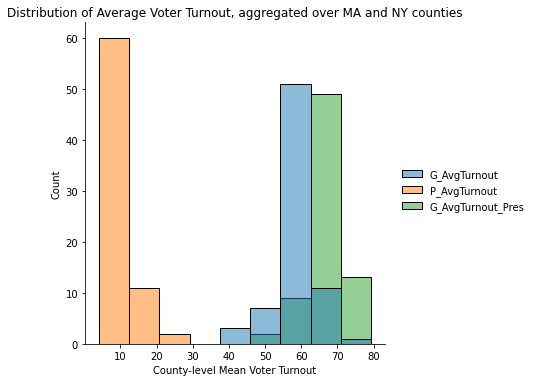

In [27]:
sns.displot(pandas_county_level_df[['G_AvgTurnout', 'P_AvgTurnout', 'G_AvgTurnout_Pres']])

# Add title and axis names
plt.title("Distribution of Average Voter Turnout, aggregated over MA and NY counties")
plt.ylabel('Count')
plt.xlabel('County-level Mean Voter Turnout');

Average turnout over all General elections follows a Normal distribution, but average turnout over either all Primary elections or over the 2008, 2012, and 2016 General elections are skewed and not bell-shaped. Furthermore, the distributions are all centered at different magnitudes of voter turnout and they all have wide turnout ranges of 30%. 

## Education & voter turnout

Let's explore the effects of education, such as whether it may explain the wide ranges or discrepancies in turnout between Primary, General, and Presidential election cycles.

In [28]:
from scipy.stats import pearsonr
## Credit: https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

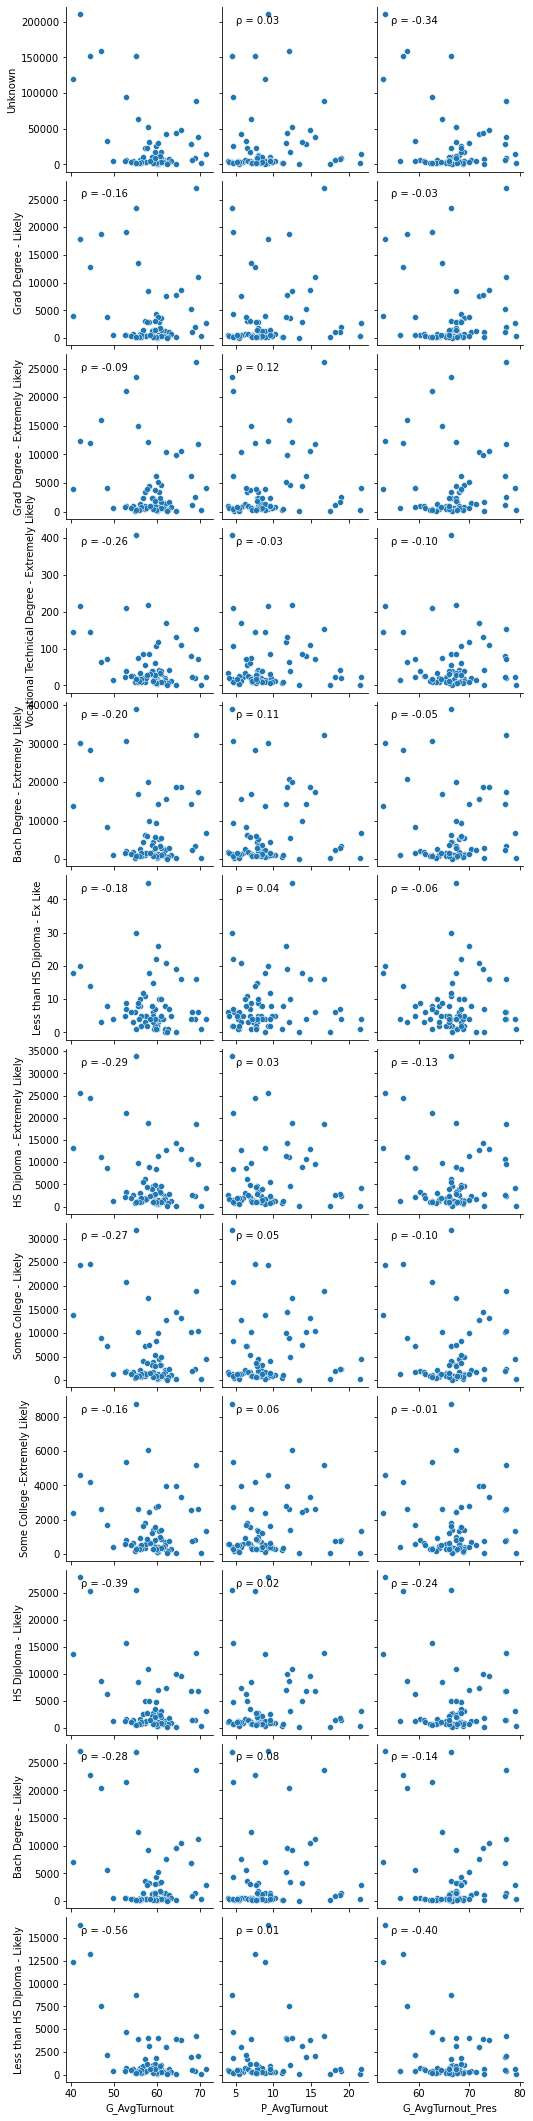

In [29]:
g = sns.pairplot(data=pandas_county_level_df,
            x_vars=['G_AvgTurnout', 'P_AvgTurnout', 'G_AvgTurnout_Pres'],
            y_vars=education_level_columns)
g.map_upper(corrfunc)
g.map_diag(corrfunc)
g.map_lower(corrfunc)
plt.show()

From the above, the largest positive correlations are:
1. Grad Degree - Ex Likely & Primary Election Average Turnout (corr = 0.12)
2. Bach Degree - Ex Likely & Primary Election Average Turnout (corr = 0.11)
3. Bach Degree - Likely & Primary Election Average Turnout (corr = 0.08)

From the above, the largest negative correlations are:
1. Less than HS Diploma - Likely & General Election Average Turnout (corr = -0.56)
2. Less than HS Diploma - Likely & General (2008, 2012, 2016) Election Average Turnout (corr = -0.40)
3. HS Diploma - Likely & General Election Average Turnout (corr = -0.39)

We have some evidence that those with a HS diploma or less are less likely to turnout to General elections, and these negative correlations are decently strong. Furthermore, we don't see evidence of strong correlation for greater education and General election turnout. Rather, the strongest positive correlations for average voter turnout present mixed results with respect to Primary elections across Grad degree and Bach degree education classes, with all weak correlations.

However, a problem with the above is that we are comparing the raw subpopulation numbers for each education class. We could convert these into a percentage to compare against the average percentage of voter turnout, but this raises another issue due to the large number of people with 'Unknown' education level that may also skew the percentages.

Instead of looking at raw education numbers, let's quickly take a look at Median years of education (50th percentile for education years) referenced against average voter turnout.

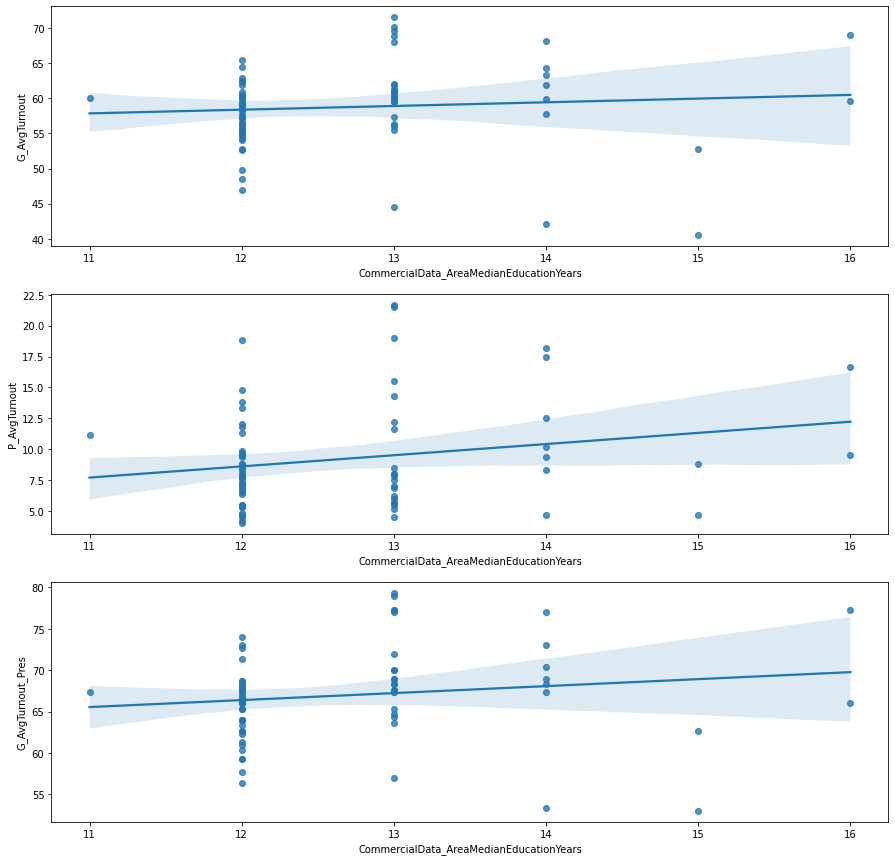

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15, 15))
sns.regplot(x = "CommercialData_AreaMedianEducationYears", y = "G_AvgTurnout", data = pandas_county_level_df, ax=ax1)
sns.regplot(x = "CommercialData_AreaMedianEducationYears", y = "P_AvgTurnout", data = pandas_county_level_df, ax=ax2)
sns.regplot(x = "CommercialData_AreaMedianEducationYears", y = "G_AvgTurnout_Pres", data = pandas_county_level_df, ax=ax3);

In [31]:
county_level_df.stat.corr("CommercialData_AreaMedianEducationYears", "G_AvgTurnout")

0.29324448383877644

In [32]:
county_level_df.stat.corr("CommercialData_AreaMedianEducationYears", "P_AvgTurnout")

0.22815881710461705

In [33]:
county_level_df.stat.corr("CommercialData_AreaMedianEducationYears", "G_AvgTurnout_Pres")

0.19214344590337795

While the correlations imply increase in average voter turnout for increasing median education years, the correlations are not strong. Notably, the correlation between education and voter turnout is strongest across General elections, followed by Primary elections and then Presidential elections. Possibly, constituents with greater education are more likely to follow news, articles, and platforms about candidates in non-Presidential General elections or Primary elections, and not just vote in the Presidential General election cycles.

### Associate with Census Educational Attainment columns
So far we've been looking at the 'CommercialData_AreaMedianEducationYears' column from the voter turnout dataset. According to the dicitionary, that column is based on 'modeled and self-reported data'. Let's now take a look at actual educational attainment data from the US Census to see if it gives us a different result.

However, we first need to do some additional processing of the Census educational attainment columns. Many of the columns are stratified across more than just education level, but also conflate classes for race, ethnicity, gender, and age. We can't aggregate those columns that are percentage estimates, so we will aggregate columns that are total population estimates. Specifically, columns that match *S1501_C01* provide total estimates that conflate just education and age, so we can sum up the estimates across the age classes for a given education class to get the estimate controlling for all other factors.

In [34]:
columns_to_drop = [column for column in county_level_df.columns if "S1501" in column if ("C01" not in column) or (column.endswith("M"))]

In [35]:
county_level_df = county_level_df.drop(*columns_to_drop)

In [36]:
county_level_df.toPandas().head()

,County,$150000-174999,$100000-124999,$75000-99999,$125000-149999,$50000-74999,$175000-199999,$35000-49999,$200000-249999,$25000-34999,...,S1501_C01_054E,S1501_C01_059E,S1501_C01_060E,S1501_C01_061E,S1501_C01_062E,S1501_C01_063E,S1501_C01_064E,G_AvgTurnout,P_AvgTurnout,G_AvgTurnout_Pres
0,ONTARIO,426,2488,4941,2132,3904,525,1506,557,786,...,633,42314,24717,32109,37964,53482,68326,61.833333,8.333333,70.333333
1,CHENANGO,64,405,1271,315,3044,67,915,64,431,...,81,37365,26478,31049,36967,44021,58770,56.333333,9.333333,64.000000
2,HAMPSHIRE,1339,4823,7149,2497,2865,876,1490,844,772,...,1821,47370,31676,39742,39990,50729,67636,68.833333,19.000000,77.333333
3,HERKIMER,115,590,1764,431,3732,82,1280,94,661,...,139,37743,31745,32203,37161,46782,60274,56.166667,9.666667,64.000000
4,CHEMUNG,121,1234,2724,678,3903,158,1414,164,1027,...,255,37963,25051,32007,34704,50807,65109,57.333333,6.000000,65.333333


In [37]:
pandas_county_level_df = county_level_df.toPandas()

In [38]:
pandas_county_level_df['census_total_population'] = pandas_county_level_df["S1501_C01_001E"] + pandas_county_level_df["S1501_C01_006E"]
pandas_county_level_df['census_perc_less_than_HS'] = 100. * (pandas_county_level_df["S1501_C01_002E"] + pandas_county_level_df["S1501_C01_007E"] + pandas_county_level_df["S1501_C01_008E"] ) / pandas_county_level_df['census_total_population']
pandas_county_level_df['census_perc_HS_grad'] = 100. * (pandas_county_level_df["S1501_C01_003E"] + pandas_county_level_df["S1501_C01_009E"] ) / pandas_county_level_df['census_total_population']
pandas_county_level_df['census_perc_some_college'] = 100. * (pandas_county_level_df["S1501_C01_004E"] + pandas_county_level_df["S1501_C01_010E"] + pandas_county_level_df["S1501_C01_011E"] ) / pandas_county_level_df['census_total_population']
pandas_county_level_df['census_perc_Bachelors'] = 100. * (pandas_county_level_df["S1501_C01_005E"] + pandas_county_level_df["S1501_C01_012E"] ) / pandas_county_level_df['census_total_population']
pandas_county_level_df['census_perc_Grad_Prof'] = 100. * (pandas_county_level_df["S1501_C01_013E"] ) / pandas_county_level_df['census_total_population']

In [39]:
pandas_county_level_df.head()

,County,$150000-174999,$100000-124999,$75000-99999,$125000-149999,$50000-74999,$175000-199999,$35000-49999,$200000-249999,$25000-34999,...,S1501_C01_064E,G_AvgTurnout,P_AvgTurnout,G_AvgTurnout_Pres,census_total_population,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof
0,ONTARIO,426,2488,4941,2132,3904,525,1506,557,786,...,68326,61.833333,8.333333,70.333333,87686,6.864266,27.260908,32.647173,18.863901,14.363752
1,CHENANGO,64,405,1271,315,3044,67,915,64,431,...,58770,56.333333,9.333333,64.000000,37672,12.144298,40.475685,29.494054,10.179975,7.705989
2,HAMPSHIRE,1339,4823,7149,2497,2865,876,1490,844,772,...,67636,68.833333,19.000000,77.333333,137922,4.574325,19.767695,37.959861,19.875727,17.822392
3,HERKIMER,115,590,1764,431,3732,82,1280,94,661,...,60274,56.166667,9.666667,64.000000,49028,9.694460,36.289467,33.931631,12.033940,8.050502
4,CHEMUNG,121,1234,2724,678,3903,158,1414,164,1027,...,65109,57.333333,6.000000,65.333333,66125,10.694896,34.791682,32.541399,12.261626,9.710397


Now let's redo our prior exploratory analysis but with the Census reported educational attainment. Note that we can't infer causation as we are making the assumption that those who responded in the Census all voted and are the only members of the county that voted. 

In [40]:
census_education_level_columns = ['census_perc_less_than_HS', 'census_perc_HS_grad', 'census_perc_some_college', 'census_perc_Bachelors', 'census_perc_Grad_Prof']

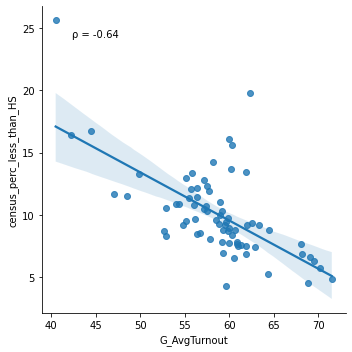

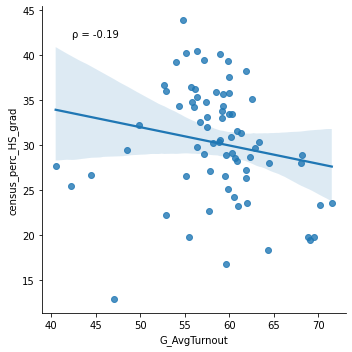

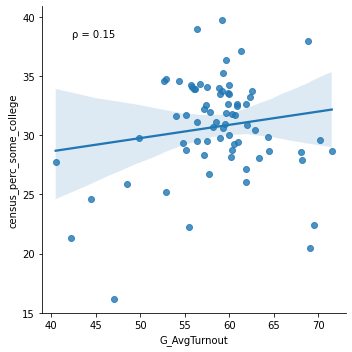

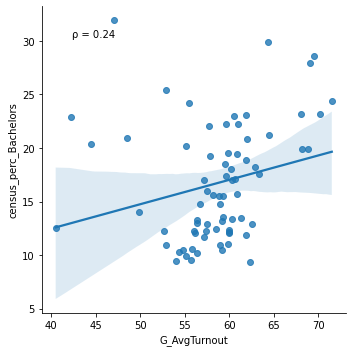

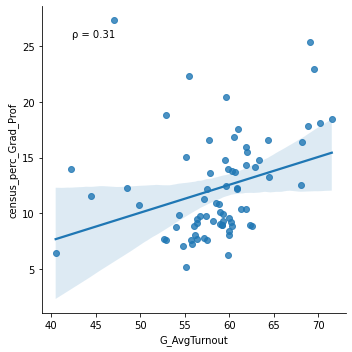

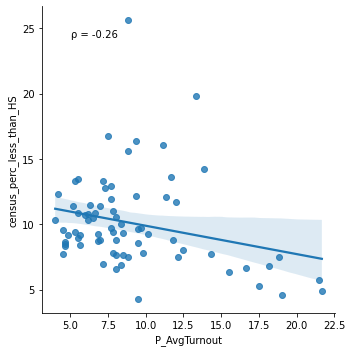

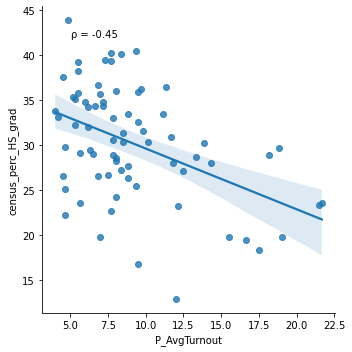

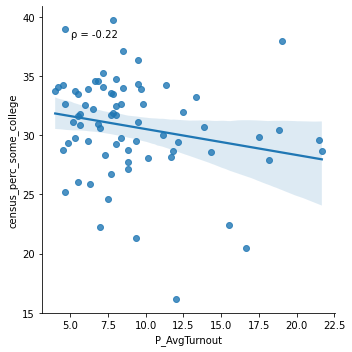

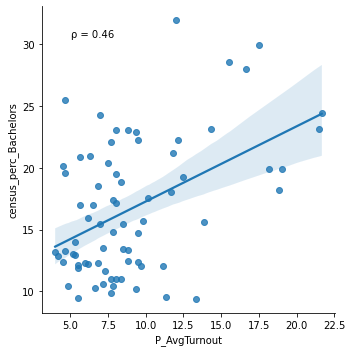

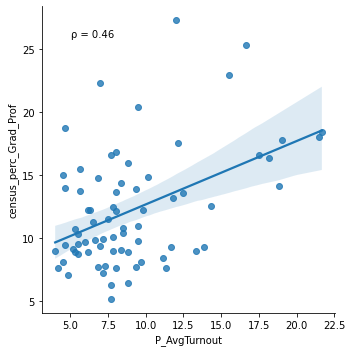

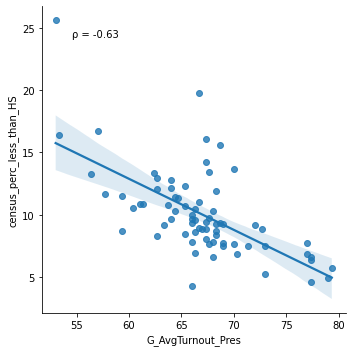

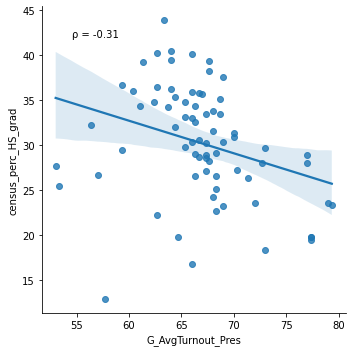

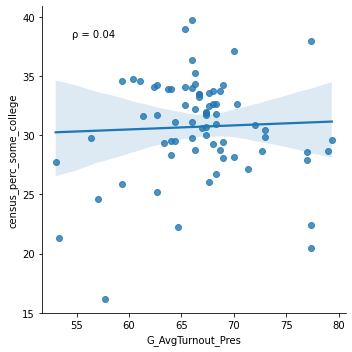

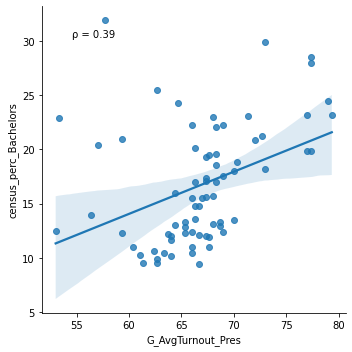

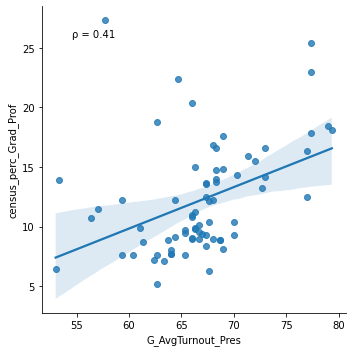

In [41]:
for _col in ["G_AvgTurnout", "P_AvgTurnout", "G_AvgTurnout_Pres"]:
    for row in census_education_level_columns:
        sns.lmplot(x=_col, y=row, data=pandas_county_level_df)
        corrfunc(pandas_county_level_df[_col], pandas_county_level_df[row])

We see much stronger trends from looking at the above plots. Let's visualize all of the correlations for easier examination.

In [42]:
edu_voter_corr = pandas_county_level_df[['census_perc_less_than_HS', 'census_perc_HS_grad', 'census_perc_some_college', 'census_perc_Bachelors', 'census_perc_Grad_Prof', "G_AvgTurnout", "P_AvgTurnout", "G_AvgTurnout_Pres"]].corr().drop(columns=census_education_level_columns)
edu_voter_corr = edu_voter_corr.drop(edu_voter_corr.index[[5,6,7]])

In [43]:
edu_voter_corr

,G_AvgTurnout,P_AvgTurnout,G_AvgTurnout_Pres
census_perc_less_than_HS,-0.639701,-0.259159,-0.634127
census_perc_HS_grad,-0.186348,-0.445999,-0.309673
census_perc_some_college,0.154688,-0.218238,0.044270
census_perc_Bachelors,0.241247,0.464806,0.385643
census_perc_Grad_Prof,0.313468,0.455764,0.407787


<AxesSubplot:>

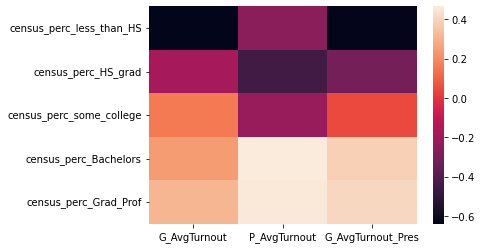

In [44]:
sns.heatmap(edu_voter_corr)

Education levels of some college or less are mostly associated with 0 or negative correlations.
We see strong negative correlations between a county's educational attainment less than HS and its average General election turnouts, regardless of the General election type. There is also a moderate negative correlation for HS grads and Primary election turnout.

Education levels of Bachelors or higher are exclusively associated with positive correlations.
We see moderate to strong correlations for Bachelors and Graduate/Professional degree subpopulations and Primary election turnout and General election turnout during Presidential election cycles.

Finally, to define the relationship between the overall education level of a county and its turnouts, we generate the *Education Score* column by:
<center>Education Score = 0 * census_perc_less_than_HS + 1 * census_perc_HS_grad + 3 * census_perc_some_college + 5 * census_perc_Bachelors + 8 * census_perc_Grad_Prof</center>

The coefficients for generating *Education Score* correspond to the number of years of education beyond HS, plus a value of 1 for completing HS. The education attainment data set describes *some college* as typically being an associates degree, so we assign it a value of 2 + 1 = 3. Following, we assume a bachelors takes 2 years beyond an associates degree, and that the professional degrees take an additional 4 years on average to complete (which gives coefficients of 5 and 8, respectively).

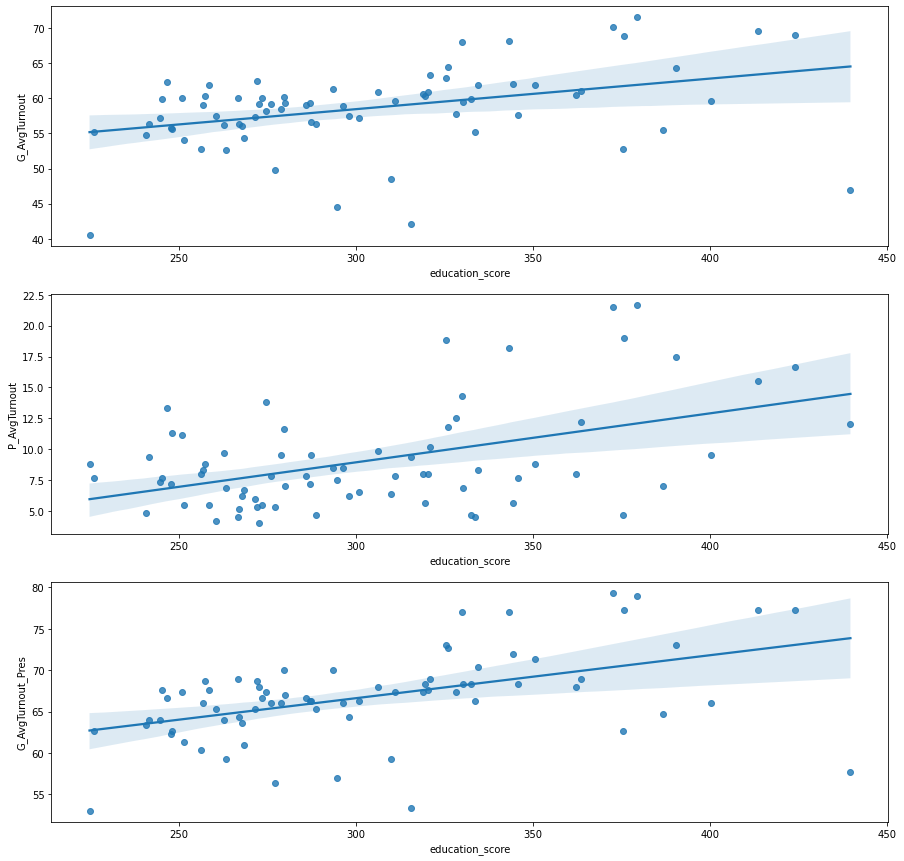

In [45]:
pandas_county_level_df['education_score'] = 0 * pandas_county_level_df['census_perc_less_than_HS'] + 1 * pandas_county_level_df['census_perc_HS_grad'] + 3 * pandas_county_level_df['census_perc_some_college'] + 5 * pandas_county_level_df['census_perc_Bachelors'] + 8 * pandas_county_level_df['census_perc_Grad_Prof']

fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15, 15))
sns.regplot(x = "education_score", y = "G_AvgTurnout", data = pandas_county_level_df, ax=ax1)
sns.regplot(x = "education_score", y = "P_AvgTurnout", data = pandas_county_level_df, ax=ax2)
sns.regplot(x = "education_score", y = "G_AvgTurnout_Pres", data = pandas_county_level_df, ax=ax3);

From the above charts, we can conclude that education level has a larger impact on primary elections than on general elections.

### How did education affect election turnouts? By increasing income?
The education level may increase turnouts in a number of ways, such as strengthening people's sense of entitlement, exercising critical thinking, and raising people's income and standard of living to give them a higher willingness to participate in politics. 
Of these, income is indicator that could be quantified easily. Therefore, we hope to combine education and income to explore the ways in which education affects voting.

First, we need to know whether higher levels of education will lead to higher incomes.

<AxesSubplot:xlabel='education_score', ylabel='CommercialData_StateIncomeDecile'>

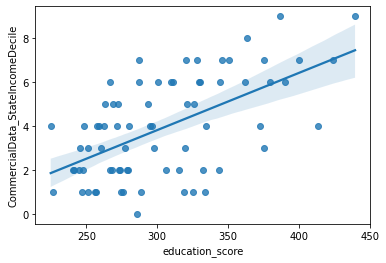

In [46]:
sns.regplot(x = "education_score", y = "CommercialData_StateIncomeDecile", data = pandas_county_level_df)

Since we know from the graph that higher education scores have higher income levels, we next need to look at the relationship between income levels and turnout.

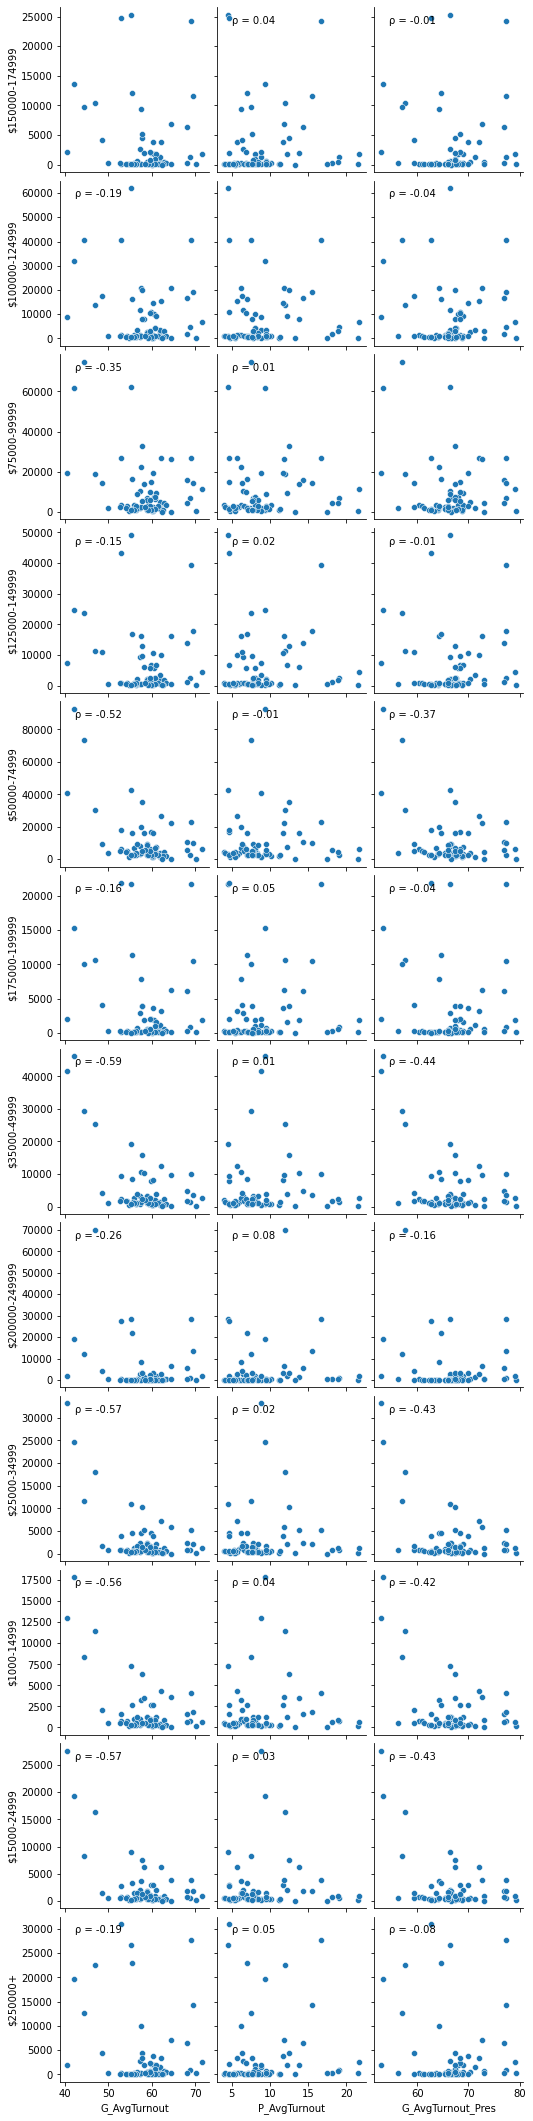

In [47]:
g = sns.pairplot(data=pandas_county_level_df,
            x_vars=['G_AvgTurnout', 'P_AvgTurnout', 'G_AvgTurnout_Pres'],
            y_vars=income_level_columns)
g.map_upper(corrfunc)
g.map_diag(corrfunc)
g.map_lower(corrfunc)
plt.show()

Although the correlation is small, essentially the number of people in each income tier is inversely correlated with turnout in the general election, positively correlated with turnout in the primary election and hybrid correlated with turnout for presidential candidates.

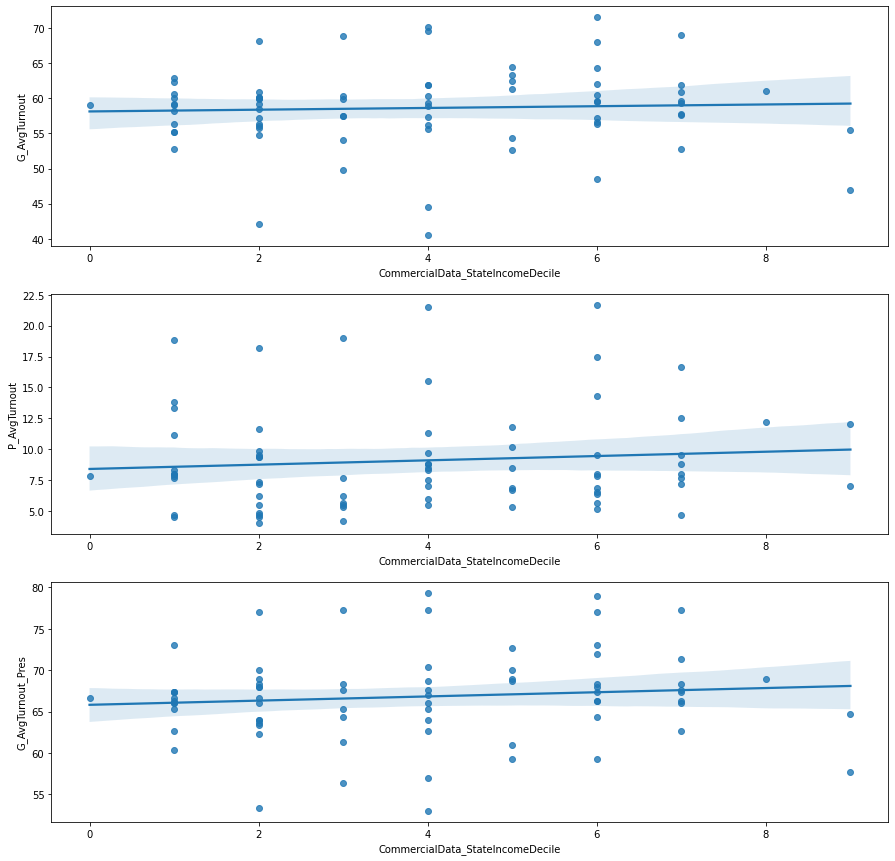

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15, 15))
sns.regplot(x = "CommercialData_StateIncomeDecile", y = "G_AvgTurnout", data = pandas_county_level_df, ax=ax1)
sns.regplot(x = "CommercialData_StateIncomeDecile", y = "P_AvgTurnout", data = pandas_county_level_df, ax=ax2)
sns.regplot(x = "CommercialData_StateIncomeDecile", y = "G_AvgTurnout_Pres", data = pandas_county_level_df, ax=ax3);

In [49]:
county_level_df.stat.corr("CommercialData_StateIncomeDecile", "G_AvgTurnout")

0.22600441434634252

In [50]:
county_level_df.stat.corr("CommercialData_StateIncomeDecile", "P_AvgTurnout")

0.0501859484641658

In [51]:
county_level_df.stat.corr("CommercialData_StateIncomeDecile", "G_AvgTurnout_Pres")

0.17194980488195782

Next, we looked at the different voter turnout for general, primary and presidential against income decile. The income shares of income deciles show how large share of the total sum of the household income in question each decile gets. The first income decile contains the lowest income tenth and the last one the highest income tenth. 

From the three graphs above there is not a clear correlation, whether positive or negative, between the three voter turnout variables and the income decile variable. Furthermore, the correlations are not strong. Notably, the correlation between income decile and voter turnout is strongest across presidential elections. Why would the top decile (wealthier households) tend to vote more for the presidential? Perhaps lower income groups tend to be less politically informed, so they may not give much importance to voting. 

In [52]:
income_level_columns = ['$150000-174999', '$100000-124999', '$75000-99999',
       '$125000-149999', '$50000-74999', '$175000-199999', '$35000-49999',
       '$200000-249999', '$25000-34999', '$1000-14999', '$15000-24999',
       '$250000+']

In [53]:
income_voter_corr = pandas_county_level_df[['$150000-174999', '$100000-124999', '$75000-99999',
       '$125000-149999', '$50000-74999', '$175000-199999', '$35000-49999',
       '$200000-249999', '$25000-34999', '$1000-14999', '$15000-24999',
       '$250000+', "G_AvgTurnout", "P_AvgTurnout", "G_AvgTurnout_Pres"]].corr().drop(columns=income_level_columns)
income_voter_corr = income_voter_corr.drop(income_voter_corr.index[[12,13,14]])

In [54]:
income_voter_corr

,G_AvgTurnout,P_AvgTurnout,G_AvgTurnout_Pres
$150000-174999,-0.127458,0.041136,-0.008602
$100000-124999,-0.190336,0.017686,-0.044548
$75000-99999,-0.353944,0.005167,-0.199055
$125000-149999,-0.147048,0.023296,-0.012442
$50000-74999,-0.517647,-0.011492,-0.373951
$175000-199999,-0.164273,0.046950,-0.042087
$35000-49999,-0.585342,0.010920,-0.437853
$200000-249999,-0.260731,0.075382,-0.162586
$25000-34999,-0.571801,0.024366,-0.431291
$1000-14999,-0.558882,0.040292,-0.417465


<AxesSubplot:>

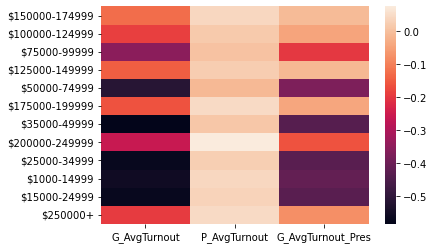

In [55]:
sns.heatmap(income_voter_corr)

As noted on previous graphs, we do not see strong positive correlations between income and turnout variables. The strongest positive correlation is around 0.08, which is quite low. However, we do see strong negative correlations for the general elections (both presidential and non-presidential). The main takeaway is that even though correlation in general is low, higher income groups tend to have more positive correlation to voter turnout compared to lower income groups. Another surprising finding is that all household income groups had negative correlation with general (presidential and non-presidential) election turnout while all household income groups have positive, albeit weak, correlation with primary election turnout (except for one decile).

For reference, we provide the education level to voter turnout correlation heat map below. We identify some overlap in strong negative correlations for voter turnout between lower income deciles and lower education levels. Thus, income is a potential confounder for education level when attempting to predict its effect on voter turnout.

<AxesSubplot:>

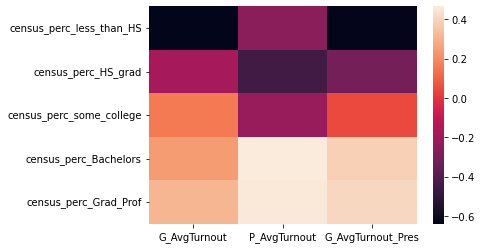

In [56]:
# Compare to the education heatmap
sns.heatmap(edu_voter_corr)

# Machine Learning Models

The target of our model is to predict county voter turnout based on features such as education levels of the constituency. Our motivation is that we could then identify the relationship between education and voter turnout, which would help guide policy recommendations on education reform or increasing civic education programs.

Our models are focused on two questions:
1. Which variables have higher importance for a county's voter turnout? 
2. Which turnout rate is more suitable for prediction by education level?

We use county_level_df to train our model, which includes average turnouts, percentage of population with different education levels, and number of people in different income brackets.

Because in our previous analysis, we found that income and education have independent effects on turnout, we decided to include income as control variables when assessing the feature importance of education level.

In [18]:
data = spark.read.parquet("gs://project_bucket_real/notebooks/jupyter/data/modeling.parquet")

In [19]:
data.toPandas().head(5)

,G_AvgTurnout,P_AvgTurnout,G_AvgTurnout_Pres,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof,150000_174999,100000_124999,75000_99999,125000_149999,50000_74999,175000_199999,35000_49999,200000_249999,25000_34999,1000_14999,15000_24999,250000_
0,57.500000,6.166667,64.333333,10.320910,31.979160,29.556351,15.949626,12.193953,192,482,449,305,387,164,211,175,96,76,71,178
1,58.833333,8.500000,66.000000,9.307582,30.377172,34.006186,15.489820,10.819240,8,53,132,39,163,10,62,13,49,30,38,10
2,60.666667,8.000000,67.333333,8.823630,28.605286,31.753080,17.135794,13.682210,19,91,136,61,138,26,36,13,26,18,24,17
3,60.000000,5.500000,66.666667,8.968765,35.840432,33.527253,12.119953,9.543597,1,8,12,5,22,1,3,0,6,1,1,1
4,61.333333,8.500000,70.000000,7.614672,31.385290,37.125610,13.453035,10.421393,4,16,49,19,53,3,27,2,5,11,9,3


## Data processing

Our conty-level voter turnout dataset is not in an appropriate format for input into MLlib's machine learning algorithms. We apply RFormula to transform our dataset into the proper format.

Further, we previously defined three election segments for analysis of voter turnout:
1. The past 6 General elections
2. The past 6 Primary elections
3. The past 3 General elections that include Presidential election (2008, 2012, 2016)

Thus, we create three subsets of our county-level voter turnout dataset. Our naming conventions for the rest of the notebook are described below:
1. Variables appended with `G_avg` match the segment of past 6 general elections
2. Variables appended with `P_avg` match the segment of past 6 primary elections
3. Variables appended with `G_avg_pres` match the segment of past 3 general elections that included Presidential election (2008, 2012, 2016)

In [20]:
data_G_avg = data.drop("P_AvgTurnout").drop("G_AvgTurnout_Pres")
data_P_avg = data.drop("G_AvgTurnout").drop("G_AvgTurnout_Pres")
data_G_avg_pres = data.drop("P_AvgTurnout").drop( "G_AvgTurnout")

supervised_G_avg = RFormula(formula="G_AvgTurnout ~ .")
supervised_P_avg = RFormula(formula="P_AvgTurnout ~ .")
supervised_G_avg_pres = RFormula(formula="G_AvgTurnout_Pres ~ .")

fittedRF_G_avg = supervised_G_avg.fit(data_G_avg)
fittedRF_P_avg = supervised_P_avg.fit(data_P_avg)
fittedRF_G_avg_pres = supervised_G_avg_pres.fit(data_G_avg_pres)

preparedDF_G_avg = fittedRF_G_avg.transform(data_G_avg)
preparedDF_P_avg = fittedRF_P_avg.transform(data_P_avg)
preparedDF_G_avg_pres = fittedRF_G_avg_pres.transform(data_G_avg_pres)

In [21]:
preparedDF_G_avg.toPandas().head(3)

22/05/02 00:38:30 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,G_AvgTurnout,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof,150000_174999,100000_124999,75000_99999,125000_149999,50000_74999,175000_199999,35000_49999,200000_249999,25000_34999,1000_14999,15000_24999,250000_,features,label
0,57.500000,10.320910,31.979160,29.556351,15.949626,12.193953,192,482,449,305,387,164,211,175,96,76,71,178,"[10.320910311321358, 31.97916000767116, 29.556...",57.500000
1,58.833333,9.307582,30.377172,34.006186,15.489820,10.819240,8,53,132,39,163,10,62,13,49,30,38,10,"[9.307581539812608, 30.37717208112977, 34.0061...",58.833333
2,60.666667,8.823630,28.605286,31.753080,17.135794,13.682210,19,91,136,61,138,26,36,13,26,18,24,17,"[8.823629565560875, 28.605286277607895, 31.753...",60.666667


We standardize the data using StandardScaler, which scales each input feature column according to the range of values in that column to have zero mean and unit variance in each dimension.

In [22]:
ss = StandardScaler(inputCol="features", outputCol="scaledFeatures")

FittedSs_G_avg = ss.fit(preparedDF_G_avg).transform(preparedDF_G_avg)
FittedSs_P_avg = ss.fit(preparedDF_P_avg).transform(preparedDF_P_avg)
FittedSs_G_avg_pres = ss.fit(preparedDF_G_avg_pres).transform(preparedDF_G_avg_pres)

If we examine the processed data, we see that the `scaledFeatures` column was correctly output to each dataset.

In [23]:
FittedSs_G_avg.toPandas().head()

,G_AvgTurnout,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof,150000_174999,100000_124999,75000_99999,125000_149999,...,175000_199999,35000_49999,200000_249999,25000_34999,1000_14999,15000_24999,250000_,features,label,scaledFeatures
0,57.500000,10.320910,31.979160,29.556351,15.949626,12.193953,192,482,449,305,...,164,211,175,96,76,71,178,"[10.320910311321358, 31.97916000767116, 29.556...",57.500000,"[2.957077072339297, 5.060968450532359, 7.05079..."
1,58.833333,9.307582,30.377172,34.006186,15.489820,10.819240,8,53,132,39,...,10,62,13,49,30,38,10,"[9.307581539812608, 30.37717208112977, 34.0061...",58.833333,"[2.6667450002077024, 4.80744051695265, 8.11232..."
2,60.666667,8.823630,28.605286,31.753080,17.135794,13.682210,19,91,136,61,...,26,36,13,26,18,24,17,"[8.823629565560875, 28.605286277607895, 31.753...",60.666667,"[2.528086369911949, 4.527024829129103, 7.57483..."
3,60.000000,8.968765,35.840432,33.527253,12.119953,9.543597,1,8,12,5,...,1,3,0,6,1,1,1,"[8.968765149941131, 35.840432162892164, 33.527...",60.000000,"[2.569669631078422, 5.672046932637733, 7.99807..."
4,61.333333,7.614672,31.385290,37.125610,13.453035,10.421393,4,16,49,19,...,3,27,2,5,11,9,3,"[7.614671844361567, 31.385289707408973, 37.125...",61.333333,"[2.181704020782869, 4.9669835287078286, 8.8564..."


In [24]:
FittedSs_P_avg.toPandas().head()

,P_AvgTurnout,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof,150000_174999,100000_124999,75000_99999,125000_149999,...,175000_199999,35000_49999,200000_249999,25000_34999,1000_14999,15000_24999,250000_,features,label,scaledFeatures
0,6.166667,10.320910,31.979160,29.556351,15.949626,12.193953,192,482,449,305,...,164,211,175,96,76,71,178,"[10.320910311321358, 31.97916000767116, 29.556...",6.166667,"[2.957077072339297, 5.060968450532359, 7.05079..."
1,8.500000,9.307582,30.377172,34.006186,15.489820,10.819240,8,53,132,39,...,10,62,13,49,30,38,10,"[9.307581539812608, 30.37717208112977, 34.0061...",8.500000,"[2.6667450002077024, 4.80744051695265, 8.11232..."
2,8.000000,8.823630,28.605286,31.753080,17.135794,13.682210,19,91,136,61,...,26,36,13,26,18,24,17,"[8.823629565560875, 28.605286277607895, 31.753...",8.000000,"[2.528086369911949, 4.527024829129103, 7.57483..."
3,5.500000,8.968765,35.840432,33.527253,12.119953,9.543597,1,8,12,5,...,1,3,0,6,1,1,1,"[8.968765149941131, 35.840432162892164, 33.527...",5.500000,"[2.569669631078422, 5.672046932637733, 7.99807..."
4,8.500000,7.614672,31.385290,37.125610,13.453035,10.421393,4,16,49,19,...,3,27,2,5,11,9,3,"[7.614671844361567, 31.385289707408973, 37.125...",8.500000,"[2.181704020782869, 4.9669835287078286, 8.8564..."


In [25]:
FittedSs_G_avg_pres.toPandas().head()

,G_AvgTurnout_Pres,census_perc_less_than_HS,census_perc_HS_grad,census_perc_some_college,census_perc_Bachelors,census_perc_Grad_Prof,150000_174999,100000_124999,75000_99999,125000_149999,...,175000_199999,35000_49999,200000_249999,25000_34999,1000_14999,15000_24999,250000_,features,label,scaledFeatures
0,64.333333,10.320910,31.979160,29.556351,15.949626,12.193953,192,482,449,305,...,164,211,175,96,76,71,178,"[10.320910311321358, 31.97916000767116, 29.556...",64.333333,"[2.957077072339297, 5.060968450532359, 7.05079..."
1,66.000000,9.307582,30.377172,34.006186,15.489820,10.819240,8,53,132,39,...,10,62,13,49,30,38,10,"[9.307581539812608, 30.37717208112977, 34.0061...",66.000000,"[2.6667450002077024, 4.80744051695265, 8.11232..."
2,67.333333,8.823630,28.605286,31.753080,17.135794,13.682210,19,91,136,61,...,26,36,13,26,18,24,17,"[8.823629565560875, 28.605286277607895, 31.753...",67.333333,"[2.528086369911949, 4.527024829129103, 7.57483..."
3,66.666667,8.968765,35.840432,33.527253,12.119953,9.543597,1,8,12,5,...,1,3,0,6,1,1,1,"[8.968765149941131, 35.840432162892164, 33.527...",66.666667,"[2.569669631078422, 5.672046932637733, 7.99807..."
4,70.000000,7.614672,31.385290,37.125610,13.453035,10.421393,4,16,49,19,...,3,27,2,5,11,9,3,"[7.614671844361567, 31.385289707408973, 37.125...",70.000000,"[2.181704020782869, 4.9669835287078286, 8.8564..."


We now randomly split each dataset into separate train and test splits, using a 70/30 train/test ratio.

In [26]:
train_G_avg, test_G_avg = FittedSs_G_avg.randomSplit(weights=[0.7,0.3], seed=843)
train_P_avg, test_P_avg = FittedSs_P_avg.randomSplit(weights=[0.7,0.3], seed=843)
train_G_avg_pres, test_G_avg_pres = FittedSs_G_avg_pres.randomSplit(weights=[0.7,0.3], seed=843)

We retrieve the name of the columns used to construct a feature vector stored in a Pandas DataFrame. This will be useful for later.

In [27]:
featureCols = pd.DataFrame(preparedDF_G_avg.drop('G_AvgTurnout').drop('features').drop('label').columns, columns = ['name'])
featureCols

,name
0,census_perc_less_than_HS
1,census_perc_HS_grad
2,census_perc_some_college
3,census_perc_Bachelors
4,census_perc_Grad_Prof
5,150000_174999
6,100000_124999
7,75000_99999
8,125000_149999
9,50000_74999


We also create a list of those features that are specific to education level, as these will be used later on when assessing importance of education level features.

In [28]:
educationCol = ['census_perc_less_than_HS','census_perc_HS_grad','census_perc_some_college','census_perc_Bachelors','census_perc_Grad_Prof']

## Modeling
For modeling, we tried ridge regression, decision tree, and random forest. As this is a regression task, we use RMSE as the evaluator.

### Model for G_avgturnout

We first try modeling average voter turnout across the past 6 general election cycles.

#### Ridge regression 
We instantiate instances for our model (`LinearRegression`) and our evaluator (`RegressionEvaluator`).

In [29]:
lr = LinearRegression(featuresCol = 'scaledFeatures', elasticNetParam = 0)

In [30]:
evaluator = RegressionEvaluator()

We won't train one `LinearRegression` model. Instead, we will train several variations specifying different values for the `regParam` hyperparameter. We hold `elasticNetParam` constant at 0, which entails an L2 penalty that defines our model as ridge regression. For validation and selection of the best model, we use `TrainValidationSplit` with a train ratio of 80%.

In [31]:
paramsGrid_lr = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.0, 0.05, 0.25, 0.5, 0.75, 1.0])\
  .build()

tvs_lr = TrainValidationSplit(estimator=lr, 
                           estimatorParamMaps=paramsGrid_lr, 
                           evaluator=evaluator,
                           parallelism=2, seed=843).setTrainRatio(0.8)

In [32]:
tvsFitted_lr_G_avg = tvs_lr.fit(train_G_avg)

22/05/02 00:38:47 WARN org.apache.spark.ml.util.Instrumentation: [83ebd262] regParam is zero, which might cause numerical instability and overfitting.
22/05/02 00:38:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/02 00:38:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/05/02 00:38:49 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/05/02 00:38:49 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/05/02 00:38:53 WARN org.apache.spark.ml.util.Instrumentation: [ee7cafa9] regParam is zero, which might cause numerical instability and overfitting.
22/05/02 00:38:54 WARN org.apache.spark.ml.util.Instrumentation: [ee7cafa9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.

Now let's extract the best performing model and see how well it does on the train and test data sets.

In [33]:
bestlr_G_avg = tvsFitted_lr_G_avg.bestModel

On the training dataset, our RMSE is about 2.32% for average voter turnout. As expected, the test dataset RMSE is higher -- around 8.25%

In [34]:
rmse_lr_G_avg_train = evaluator.evaluate(bestlr_G_avg.transform(train_G_avg), {evaluator.metricName: "rmse"})
rmse_lr_G_avg_test = evaluator.evaluate(bestlr_G_avg.transform(test_G_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_lr_G_avg_train)
print("RMSE for test dataset", rmse_lr_G_avg_test)

RMSE for train dataset 2.32310796539245
RMSE for test dataset 8.254549250171191


#### Decision tree 
We instantiate instances for our model (`DecisionTreeRegressor`). Like with the ridge regression model, we will conduct a hyperparameter search to find and extract the best hyperparameter combination. We will then take the best model and evaluate it in terms of RMSE.

In the case of the Decision Tree, we will search over: \
1. `maxDepth`: Maximum depth of a tree. Higher `maxDepth` entails greater expressivity, but also greater computational cost and chance of overfitting. \
2. `maxBins`: Number of bins used when discretizing continuous features. Higher `maxBins` entails finer-grained split decisions, but also greater computational cost.

In [35]:
tree = DecisionTreeRegressor(featuresCol = 'scaledFeatures', seed = 843)

In [36]:
paramsGrid_tree = ParamGridBuilder()\
  .addGrid(tree.maxDepth, [5,15,25])\
  .addGrid(tree.maxBins, [20,30,40])\
  .build()

tvs_tree = TrainValidationSplit(estimator=tree, 
                           estimatorParamMaps=paramsGrid_tree, 
                           evaluator=evaluator,
                           parallelism=2, seed=843).setTrainRatio(0.8)

In [37]:
tvsFitted_tree_G_avg = tvs_tree.fit(train_G_avg)

In [38]:
besttree_G_avg = tvsFitted_tree_G_avg.bestModel

In [39]:
rmse_tree_G_avg_train = evaluator.evaluate(besttree_G_avg.transform(train_G_avg), {evaluator.metricName: "rmse"})
rmse_tree_G_avg_test = evaluator.evaluate(besttree_G_avg.transform(test_G_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_tree_G_avg_train)
print("RMSE for test dataset", rmse_tree_G_avg_test)

RMSE for train dataset 1.828807846475349
RMSE for test dataset 5.826257081066647


It looks like the Decision Tree performs better than the Ridge Regressor. Note that we shouldn't base this decision on test dataset performance, as this is not good practice and such human intervention can lead to overfitting. The train dataset RMSE and test dataset RMSE are 1.83% and 5.83%, respectively. These are both better than the Ridge Regressor's performance.

#### Random forest
We instantiate instances for our model (`RandomForestRegressor`). We again conduct a hyperparameter search to find and extract the best hyperparameter combination. We will then take the best model and evaluate it in terms of RMSE.

In the case of the Random Forest, we will search over: \
1. `maxDepth`: Maximum depth of each tree. Higher `maxDepth` entails greater expressivity, but also greater computational cost and chance of overfitting. \
2. `maxBins`: Number of bins used when discretizing continuous features. Higher `maxBins` entails finer-grained split decisions, but also greater computational cost. \
3. `numTrees`: Number of trees in the random forest. \
4. `featureSubsetStrategy`: Number of features to consider for splits at each node. Since `numTrees` is always greater than 1, we don't include `auto` as an option in the search since `auto` will be set to `sqrt` if `numTrees` > 1.

In [40]:
rf = RandomForestRegressor(featuresCol = 'scaledFeatures', seed = 843)

In [41]:
paramsGrid_rf = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [5,10])\
  .addGrid(rf.maxBins, [20,30,40])\
  .addGrid(rf.numTrees, [20,30])\
  .addGrid(rf.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2'])\
  .build()

tvs_rf = TrainValidationSplit(estimator=rf, 
                           estimatorParamMaps=paramsGrid_rf, 
                           evaluator=evaluator,
                           parallelism=2, seed=843).setTrainRatio(0.8)

In [42]:
tvsFitted_rf_G_avg = tvs_rf.fit(train_G_avg)

In [43]:
bestrf_G_avg = tvsFitted_rf_G_avg.bestModel

In [44]:
rmse_rf_G_avg_train = evaluator.evaluate(bestrf_G_avg.transform(train_G_avg), {evaluator.metricName: "rmse"})
rmse_rf_G_avg_test = evaluator.evaluate(bestrf_G_avg.transform(test_G_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_rf_G_avg_train)
print("RMSE for test dataset", rmse_rf_G_avg_test)

RMSE for train dataset 1.725757416577847
RMSE for test dataset 4.065130320425051


The Random Forest outperformed both the Decision Tree and Ridge Regressor at predicted average voter turnout for general election cycles. Our Random Forest model is what we will use for predicting average voter turnout for general election cycles.

#### Feature importance

Now, let's examine how each model places importance on the dataset features. Specifically, we want to understand the interplay between the education level features. We'll extract the feature coefficients learned by each model, and take the subset of education features. By also having the model's trained with income level features, we have been able to better control for the confounding effect income may have had on education level interpretation.

In [45]:
coefsArray = np.array(bestlr_G_avg.coefficients)
coefsDF_G_avg = pd.DataFrame(coefsArray, columns=['Ridge'])
coefsDF_G_avg = featureCols.merge(coefsDF_G_avg, left_index=True, right_index=True)

coefsArray = np.array(besttree_G_avg.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Decision Tree'])
coefsDF_G_avg = coefsDF_G_avg.merge(coefsDF_2, left_index=True, right_index=True)

coefsArray = np.array(bestrf_G_avg.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Random Forest'])
coefsDF_G_avg = coefsDF_G_avg.merge(coefsDF_2, left_index=True, right_index=True)

coefsDF_G_avg['Average'] = (abs(coefsDF_G_avg['Ridge']) + coefsDF_G_avg['Decision Tree'] + coefsDF_G_avg['Random Forest'])/3

coefsDF_education_G_avg = coefsDF_G_avg[:5].sort_values('Average')

The coefficients of the ridge regressor denote that, from the model's perspective, all but the *higher than college* education level have a negative impact, which means the increase in population proportion of other educational levels will lead to the decrease in the general turnout.

In [46]:
coefsDF_education_G_avg

,name,Ridge,Decision Tree,Random Forest,Average
3,census_perc_Bachelors,-0.063360,0.000000,0.045002,0.036121
1,census_perc_HS_grad,-0.259428,0.006672,0.068940,0.111680
2,census_perc_some_college,-0.841983,0.025636,0.030758,0.299459
0,census_perc_less_than_HS,-0.688664,0.272283,0.180194,0.380380
4,census_perc_Grad_Prof,1.739241,0.070289,0.053195,0.620909


We further compare feature importances across the tree-based models. For making predictions, the tree-based models place highest feature importance on the *less than high school* education level. For the decision tree, the remaining features aside from *graduate / higher than college* have very low importance in deciding voter turnout. Thus, the two extremes of the education level bins (*less than high school* and *graduate / higher than college*) are most informative. For the random forest, *HS graduate* is the second most important feature, with *graduate / higher than college* and *Bachelors* having some influence and *some college* having almost no influence.

<AxesSubplot:>

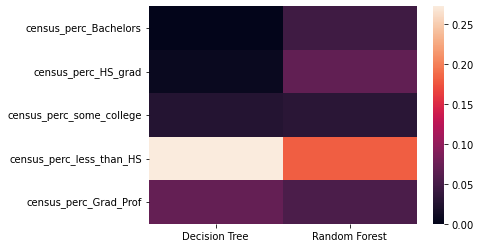

In [47]:
sns.heatmap(coefsDF_education_G_avg[['Decision Tree', 'Random Forest']], yticklabels=coefsDF_education_G_avg['name'])

#### Average RMSE

We'll also compute the average RMSE across the 3 models as a comparison for evalutaing how easy or hard this prediction task is relative to the other two.

In [48]:
rmse_train_G_avg = (rmse_lr_G_avg_train + rmse_tree_G_avg_train + rmse_rf_G_avg_train) / 3
rmse_test_G_avg = (rmse_lr_G_avg_test + rmse_tree_G_avg_test + rmse_rf_G_avg_test) / 3
print("Average RMSE for train dataset", rmse_train_G_avg)
print("Average RMSE for test dataset", rmse_test_G_avg)

Average RMSE for train dataset 1.959224409481882
Average RMSE for test dataset 6.048645550554297


### Model for P_avgturnout

Now, we will model average voter turnout across the past 6 primary election cycles.

We will use the same strategy of training and comparing three models -- ridge regression, decision tree, and random forest -- searching over the same hyperparameter space to extract the best performing model.

#### Ridge regression

In [49]:
tvsFitted_lr_P_avg = tvs_lr.fit(train_P_avg)
bestlr_P_avg = tvsFitted_lr_P_avg.bestModel
rmse_lr_P_avg_train = evaluator.evaluate(bestlr_P_avg.transform(train_P_avg), {evaluator.metricName: "rmse"})
rmse_lr_P_avg_test = evaluator.evaluate(bestlr_P_avg.transform(test_P_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_lr_P_avg_train)
print("RMSE for test dataset", rmse_lr_P_avg_test)

22/05/02 00:40:07 WARN org.apache.spark.ml.util.Instrumentation: [da482ccb] regParam is zero, which might cause numerical instability and overfitting.
22/05/02 00:40:07 WARN org.apache.spark.ml.util.Instrumentation: [da482ccb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


RMSE for train dataset 3.270620633082699
RMSE for test dataset 4.049467921474852


#### Decision tree

In [50]:
tvsFitted_tree_P_avg = tvs_tree.fit(train_P_avg)
besttree_P_avg = tvsFitted_tree_P_avg.bestModel
rmse_tree_P_avg_train = evaluator.evaluate(besttree_P_avg.transform(train_P_avg), {evaluator.metricName: "rmse"})
rmse_tree_P_avg_test = evaluator.evaluate(besttree_P_avg.transform(test_P_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_tree_P_avg_train)
print("RMSE for test dataset", rmse_tree_P_avg_test)

RMSE for train dataset 1.4984311059005566
RMSE for test dataset 3.1205011395486717


#### Random forest

In [51]:
tvsFitted_rf_P_avg = tvs_rf.fit(train_P_avg)
bestrf_P_avg = tvsFitted_rf_P_avg.bestModel
rmse_rf_P_avg_train = evaluator.evaluate(bestrf_P_avg.transform(train_P_avg), {evaluator.metricName: "rmse"})
rmse_rf_P_avg_test = evaluator.evaluate(bestrf_P_avg.transform(test_P_avg), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_rf_P_avg_train)
print("RMSE for test dataset", rmse_rf_P_avg_test)

RMSE for train dataset 1.6156642729178048
RMSE for test dataset 3.150916613407327


Like the task of predicting voter turnout on general elections, ridge regression was the worst performing model. However, this time the decision tree edged out the random forest model, achieving the lowest RMSE on both the train and test data sets.

#### Feature importance

Now, let's examine how each model places importance on the dataset features. Specifically, we want to understand the interplay between the education level features. We'll extract the feature coefficients learned by each model, and take the subset of education features. By also having the model's trained with income level features, we have been able to better control for the confounding effect income may have had on education level interpretation.

In [52]:
coefsArray = np.array(bestlr_P_avg.coefficients)
coefsDF_P_avg = pd.DataFrame(coefsArray, columns=['Ridge'])
coefsDF_P_avg = featureCols.merge(coefsDF_P_avg, left_index=True, right_index=True)

coefsArray = np.array(besttree_P_avg.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Decision Tree'])
coefsDF_P_avg = coefsDF_P_avg.merge(coefsDF_2, left_index=True, right_index=True)

coefsArray = np.array(bestrf_P_avg.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Random Forest'])
coefsDF_P_avg = coefsDF_P_avg.merge(coefsDF_2, left_index=True, right_index=True)

coefsDF_P_avg['Average'] = (abs(coefsDF_P_avg['Ridge']) + coefsDF_P_avg['Decision Tree'] + coefsDF_P_avg['Random Forest'])/3

coefsDF_education_P_avg = coefsDF_P_avg[:5].sort_values('Average', ascending=False)

*high school graduation* and *less than high school* have negative impacts, which means the increase in population proportion of these two educational levels will lead to a decrease in primary election voter turnout

In [53]:
coefsDF_education_P_avg

,name,Ridge,Decision Tree,Random Forest,Average
3,census_perc_Bachelors,1.405306,0.097491,0.196929,0.566575
1,census_perc_HS_grad,-1.155375,0.016828,0.130252,0.434152
0,census_perc_less_than_HS,-0.023576,0.569469,0.342963,0.312003
4,census_perc_Grad_Prof,0.033312,0.000000,0.061256,0.031523
2,census_perc_some_college,0.017282,0.012821,0.035014,0.021706


For making predictions on primary voter turnout, the tree models again place greatest information gain on *less than HS* education level, followed by the *Bachelors* education level. The magnitude of importance on *less than HS* is much higher though, compared to its magnitude of importance for predicting general election turnout.

<AxesSubplot:>

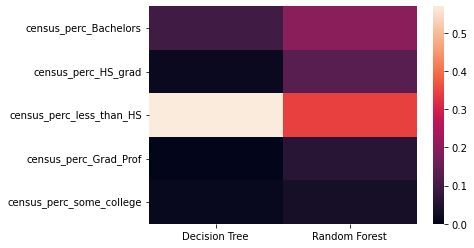

In [54]:
sns.heatmap(coefsDF_education_P_avg[['Decision Tree', 'Random Forest']], yticklabels=coefsDF_education_P_avg['name'])

#### Average RMSE

Compared to the task of predicting average voter turnout for general election cycles, the three model families achieved a higher aggregate train RMSE for predicting primary election cycle turnout. Nevertheless, they achieved a lower aggregate test RMSE. These results in tandem indicate that the models did not overfit and, thus, were better able to generalize when predicting primary election turnout (compared to general election turnout).

In [55]:
rmse_train_P_avg = (rmse_lr_P_avg_train + rmse_tree_P_avg_train + rmse_rf_P_avg_train) / 3
rmse_test_P_avg = (rmse_lr_P_avg_test + rmse_tree_P_avg_test + rmse_rf_P_avg_test) / 3
print("Average RMSE for train dataset", rmse_train_P_avg)
print("Average RMSE for test dataset", rmse_test_P_avg)

Average RMSE for train dataset 2.1282386706336864
Average RMSE for test dataset 3.4402952248102836


### Model for G_avgturnout_pres

Now, we will model average voter turnout across the past 3 presidential elections.

We will use the same strategy of training and comparing three models -- ridge regression, decision tree, and random forest -- searching over the same hyperparameter space to extract the best performing model.

#### Ridge regression

In [56]:
tvsFitted_lr_G_avg_pres = tvs_lr.fit(train_G_avg_pres)
bestlr_G_avg_pres = tvsFitted_lr_G_avg_pres.bestModel
rmse_lr_G_avg_pres_train = evaluator.evaluate(bestlr_G_avg_pres.transform(train_G_avg_pres), {evaluator.metricName: "rmse"})
rmse_lr_G_avg_pres_test = evaluator.evaluate(bestlr_G_avg_pres.transform(test_G_avg_pres), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_lr_G_avg_pres_train)
print("RMSE for test dataset", rmse_lr_G_avg_pres_test)

22/05/02 00:40:53 WARN org.apache.spark.ml.util.Instrumentation: [4fd9fc1d] regParam is zero, which might cause numerical instability and overfitting.
22/05/02 00:40:53 WARN org.apache.spark.ml.util.Instrumentation: [4fd9fc1d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


RMSE for train dataset 3.029465248528684
RMSE for test dataset 4.504754292665092


#### Decision tree

In [57]:
tvsFitted_tree_G_avg_pres = tvs_tree.fit(train_G_avg_pres)
besttree_G_avg_pres = tvsFitted_tree_G_avg_pres.bestModel
rmse_tree_G_avg_pres_train = evaluator.evaluate(besttree_G_avg_pres.transform(train_G_avg_pres), {evaluator.metricName: "rmse"})
rmse_tree_G_avg_pres_test = evaluator.evaluate(besttree_G_avg_pres.transform(test_G_avg_pres), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_tree_G_avg_pres_train)
print("RMSE for test dataset", rmse_tree_G_avg_pres_test)

RMSE for train dataset 8.439364330324543e-15
RMSE for test dataset 3.3606722016672195


#### Random forest

In [58]:
tvsFitted_rf_G_avg_pres = tvs_rf.fit(train_G_avg_pres)
bestrf_G_avg_pres = tvsFitted_rf_G_avg_pres.bestModel
rmse_rf_G_avg_pres_train = evaluator.evaluate(bestrf_G_avg_pres.transform(train_G_avg_pres), {evaluator.metricName: "rmse"})
rmse_rf_G_avg_pres_test = evaluator.evaluate(bestrf_G_avg_pres.transform(test_G_avg_pres), {evaluator.metricName: "rmse"})
print("RMSE for train dataset", rmse_rf_G_avg_pres_train)
print("RMSE for test dataset", rmse_rf_G_avg_pres_test)

RMSE for train dataset 1.8120338636109332
RMSE for test dataset 3.8386240690446973


We note similar model performance trends to predicting voter turnout on primary elections -- decision tree performed best on both train and test data sets, followed by random forest and then the ridge regressor.

#### Feature importance

In [59]:
coefsArray = np.array(bestlr_G_avg_pres.coefficients)
coefsDF_G_avg_pres = pd.DataFrame(coefsArray, columns=['Ridge'])
coefsDF_G_avg_pres = featureCols.merge(coefsDF_G_avg_pres, left_index=True, right_index=True)

coefsArray = np.array(besttree_G_avg_pres.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Decision Tree'])
coefsDF_G_avg_pres = coefsDF_G_avg_pres.merge(coefsDF_2, left_index=True, right_index=True)

coefsArray = np.array(bestrf_G_avg_pres.featureImportances)
coefsDF_2 = pd.DataFrame(coefsArray, columns=['Random Forest'])
coefsDF_G_avg_pres = coefsDF_G_avg_pres.merge(coefsDF_2, left_index=True, right_index=True)

coefsDF_G_avg_pres['Average'] = (abs(coefsDF_G_avg_pres['Ridge']) + coefsDF_G_avg_pres['Decision Tree'] + coefsDF_G_avg_pres['Random Forest'])/3

coefsDF_education_G_avg_pres = coefsDF_G_avg_pres[:5].sort_values('Average', ascending=False)

*higher than college* and *Bachelor degree* have positive impacts, which means that an increase in population proportion of these two educational levels may lead to an increase in the turnout of general elections that coincide with a presidential election. 

In [60]:
coefsDF_education_G_avg_pres

,name,Ridge,Decision Tree,Random Forest,Average
0,census_perc_less_than_HS,-1.341839,0.442099,0.380701,0.721546
4,census_perc_Grad_Prof,1.175311,0.007221,0.053949,0.412160
3,census_perc_Bachelors,0.877985,0.129562,0.085387,0.364312
2,census_perc_some_college,-0.581186,0.072240,0.106219,0.253215
1,census_perc_HS_grad,-0.447931,0.043164,0.037110,0.176068


For making predictions on primary voter turnout, the tree models again place greatest information gain on *less than HS* education level. The magnitude of importance on *less than HS* is a little less than its magnitude of importance for predicting primary election turnout.

<AxesSubplot:>

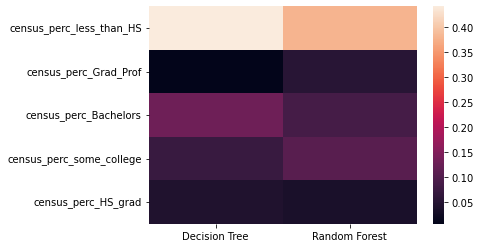

In [61]:
sns.heatmap(coefsDF_education_G_avg_pres[['Decision Tree', 'Random Forest']], yticklabels=coefsDF_education_G_avg_pres['name'])

#### Average RMSE

Compared to the previous two tasks, the aggregate train dataset performance was ordered, from lowest to highest RMSE, general election turnout, presidential election turnout, primary election turnout. The aggregate test dataset performance was ordered, from lowest to highest RMSE, primary election turnout, presidential election turnout, general election turnout. Thus, the models, in aggregate, best generalized to the primary election turnout task, followed by presidential election turnout and then general election turnout.

In [62]:
rmse_train_G_avg_pres = (rmse_lr_G_avg_pres_train + rmse_tree_G_avg_pres_train + rmse_rf_G_avg_pres_train) / 3
rmse_test_G_avg_pres = (rmse_lr_G_avg_pres_test + rmse_tree_G_avg_pres_test + rmse_rf_G_avg_pres_test) / 3
print("Average RMSE for train dataset", rmse_train_G_avg_pres)
print("Average RMSE for test dataset", rmse_test_G_avg_pres)

Average RMSE for train dataset 1.613833037379875
Average RMSE for test dataset 3.9013501877923367


## Modeling Conclusions

### Feature importance

Recall that we previously looked at feature importance across the three models for each of the three tasks -- general election, primary election, and presidential election voter turnout. As a recap, we print the feature importance below for each task.

In [63]:
coefsDF_G_avg[coefsDF_G_avg['name'].isin(educationCol)]

,name,Ridge,Decision Tree,Random Forest,Average
0,census_perc_less_than_HS,-0.688664,0.272283,0.180194,0.380380
1,census_perc_HS_grad,-0.259428,0.006672,0.068940,0.111680
2,census_perc_some_college,-0.841983,0.025636,0.030758,0.299459
3,census_perc_Bachelors,-0.063360,0.000000,0.045002,0.036121
4,census_perc_Grad_Prof,1.739241,0.070289,0.053195,0.620909


In [64]:
coefsDF_P_avg[coefsDF_P_avg['name'].isin(educationCol)]

,name,Ridge,Decision Tree,Random Forest,Average
0,census_perc_less_than_HS,-0.023576,0.569469,0.342963,0.312003
1,census_perc_HS_grad,-1.155375,0.016828,0.130252,0.434152
2,census_perc_some_college,0.017282,0.012821,0.035014,0.021706
3,census_perc_Bachelors,1.405306,0.097491,0.196929,0.566575
4,census_perc_Grad_Prof,0.033312,0.000000,0.061256,0.031523


In [65]:
coefsDF_G_avg_pres[coefsDF_G_avg_pres['name'].isin(educationCol)]

,name,Ridge,Decision Tree,Random Forest,Average
0,census_perc_less_than_HS,-1.341839,0.442099,0.380701,0.721546
1,census_perc_HS_grad,-0.447931,0.043164,0.037110,0.176068
2,census_perc_some_college,-0.581186,0.072240,0.106219,0.253215
3,census_perc_Bachelors,0.877985,0.129562,0.085387,0.364312
4,census_perc_Grad_Prof,1.175311,0.007221,0.053949,0.412160


Regarding the relationship between education level and voter turnout, we saw that an education *higher than college* was associated with positive voter turnout for all three election types. In contrast, education levels *less than high school* and *high school graduate* were both associated with negative voter turnout for all three election types. In the middle, *Bachelors* was positively associated with primary and presidential elections, while *some college* was only positively associated for priamry elections.

Furthermore, an education level of *less than high school* had notable more feature importance for the tree-based models than any other education level, regardless of election cycle. The only influence of election cycle was the magnitude of that feature importance, with it being greatest for Primary election cycles.

In tandem, these findings indicate that Primary election cycle voter turnout is most sensitive to a constituency with higher levels of education. Also, the higher the education level, the greater the positive association with voting -- to the point that an education of *higher than college* is positively associated with voter turnout for all election types. On the other hand, having a proportionally higher *less than high school* educated population is a highly important marker of lowered voter turnout for all election types we analyzed.

In general, higher than college have positive impacts on general elections, primary elections and precidential elections. Though bachelors degree have small negative impact on general elections, it have positive impact on the other two elections and have high importance. Thus, in order to encourage people participate in elections, measures should be adopted to encourage residents to go to college. We have following suggestions:
- Improve the educational level of basic education and develop students' interest in learning from an early age.
- Reduce tuition fees at public universities.
- Reduce the interest rate of student loans.
- Encourage working people to enroll in part-time undergraduate or graduate programs.

### Model applicability

|Target variable|Avg RMSE for train|Avg RMSE for test|
|----|----|----|
|General turnout|1.96|6.04|
|Primary turnout|2.13|3.44|
|General turnout (precidential)|1.61|3.90|

Though general turnout have relatively small average RMSE, it has the highest average RMSE for test, which means the models do not generalize well. Primary turnout have the highest average RMSE for train but lowest average RMSE for test. General turnout (presidential) have the lowest average RMSE for train and moderate average RMSE for test. In aggregate, the models were less liable to overfit on the primary turnout task.

Because our attempts are still few, it is not very rigorous to draw direct conclusions about which variable is more appropriate to predict with education level. However, from our results, the primary and general elections (presidential) may be more worthy of further study.

## Modeling Limitations

- Because we only considered NY and MA, and our models are biult on county-level, the sample size is limited.
- The average turnouts are calculated based on the the elections in the past six years. There is no guarantee that we will see the same trend in the future.

If we got a chance of future exploration, there are few ways to improve our model.

Improve models:
- Larger sample size.
- More gridsearch parameters.

Increase sample size:
- Include more states in our dataset.
- Find data on the demographic distribution of education levels for each county for the past six years and combine it with our existing voter turnout for each counry for the past six years, so that our sample size becomes 6 * the total number of couties.

# Conclusion

**The impact of education levels on election turnouts.** 
- Higher overall education levels of counties lead to higher voter turnout, and education levels have a greater impact on primary election turnout.
- Specificaly, for general election turnout, *some college*, *bachelors* and *grad,prof* have positive impacts, while *less than high school* and *high school* have negative impacts. For primary election turnout, *bachelors* and *grad,prof* have larger positive impacts, while *some college*, *less than high school* and *high school* have negative impacts.

**We do not think income would exacerbate the impact of education levels on election turnouts.** 
- Higher overall education will bring higher income level for a county.
- However, all the income levels have negative impacts on general election turnouts, and all the income levels have positive impacts on primary election turnouts. And the overall income level of counties has similar impacts on general and primary election turnouts.
- If higher education is what increases turnout through higher income, then higher income should result in higher turnout, and the correlation between overall district income levels and primary elections should be greater. But this is not the case.

**Possible next steps:** 
- Investigate on individual-level
- Combine education with other factors, like donating actions, interest in religious inspirational, if the individual is an investor, etc., to find out the approach of the education influencing the election turnout.
- Integrate additional data from recent elections, such as the 2020 general (presidential) elections
- Investigate whether voter turnout behavior and its relation to education level is dependent on state or region (e.g., West Coast, East Coast, Midwest, South)